# *PSET5 — Modelamiento Predictivo con Ensambles Gradient Boosting*

## *Portada*

*Curso:* Aprendizaje Automático / Machine Learning  
*Práctica:* PSET5 — Ensambles, Boosting y Modelos Basados en Árboles  
*Tema:* Predicción del monto total (TOTAL_AMOUNT) mediante modelos de boosting y ensambles  
*Integrantes:* Ahmed, Martina, Mary, Joel  


## *Resumen del Experimento*

Este experimento implementa un flujo completo de modelamiento predictivo orientado a estimar el valor monetario **TOTAL_AMOUNT** utilizando datos estructurados con marca temporal. El análisis sigue un enfoque riguroso de *split temporal*, donde el conjunto de entrenamiento abarca enero–octubre 2015, validación comprende noviembre–diciembre 2015, y prueba corresponde a todo el 2016. Este esquema preserva la naturaleza cronológica y evita filtración de información futura.

Se trabaja con un conjunto de *características numéricas y categóricas, las cuales se preprocesan mediante codificación *one-hot y normalización cuando corresponde. Los principales algoritmos evaluados fueron:

- *LightGBM (GBDT clásico)*  
- *XGBoost*  
- *CatBoost*  
- Ensambles adicionales (Voting, Bagging, Pasting, AdaBoost)  
- Modelos base simples (media y regresión lineal)

Cada modelo se entrenó y evaluó midiendo *RMSE, **MAE* y *R²* tanto en validación como en test final. Además, se generó una tabla comparativa consolidada y visualizaciones que muestran el desempeño relativo entre modelos.

Los resultados indican que los métodos basados en *Gradient Boosting* superan ampliamente a las líneas base, con mejoras notables en error absoluto y cuadrático. LightGBM y XGBoost destacan como los modelos más estables y eficientes, obteniendo las mejores métricas en el conjunto de prueba. El análisis confirma que los ensambles boosting son especialmente adecuados para datos tabulares con interacciones no lineales y patrones dependientes del tiempo.


## iNSTALACIÓN DE LIBRERIAS

In [1]:
!pip install --quiet --no-cache-dir --force-reinstall \
    numpy==1.26.4 \
    pandas==2.1.4 \
    scipy==1.11.4 \
    scikit-learn==1.3.2 \
    lightgbm==4.2.0 \
    xgboost \
    catboost \
    shap \
    snowflake-connector-python

import numpy as np, pandas as pd, scipy, sklearn, lightgbm as lgb

print("✅ Instalación completada.\n")
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("SciPy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("LightGBM:", lgb.__version__)

print("\n⚠️ Reinicia el kernel antes de continuar.")


✅ Instalación completada.

NumPy: 1.26.4
Pandas: 2.1.4
SciPy: 1.11.4
scikit-learn: 1.3.2
LightGBM: 4.2.0

⚠️ Reinicia el kernel antes de continuar.


## Libreias y configuración

In [3]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pickle

# Conexión a Snowflake
import snowflake.connector

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelos base
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Ensambles
from sklearn.ensemble import (
    VotingRegressor, BaggingRegressor, 
    AdaBoostRegressor, GradientBoostingRegressor,
    RandomForestRegressor
)

# Boosting avanzado
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Interpretabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Librerías cargadas correctamente")
print(f"Versión XGBoost: {xgb.__version__}")
print(f"Versión LightGBM: {lgb.__version__}")

✅ Librerías cargadas correctamente
Versión XGBoost: 3.1.1
Versión LightGBM: 4.2.0


## Implementación Times Serie Splite

In [4]:

print("\n" + "="*80)
print("CONFIGURACIÓN TIMESERIESSPLIT - VALIDACIÓN TEMPORAL")
print("="*80)

# Configurar TimeSeriesSplit para validación temporal
tscv = TimeSeriesSplit(n_splits=3)

print("✅ TimeSeriesSplit configurado con 3 splits")
print("   Garantiza validación temporal sin data leakage")


CONFIGURACIÓN TIMESERIESSPLIT - VALIDACIÓN TEMPORAL
✅ TimeSeriesSplit configurado con 3 splits
   Garantiza validación temporal sin data leakage


## Conexión Snowflake

In [5]:

print("\n" + "="*80)
print("CONEXIÓN A SNOWFLAKE")
print("="*80)

def get_snowflake_conn():
    """Establece conexión a Snowflake"""
    return snowflake.connector.connect(
        user="mariamoncayo",
        password="Mariamoncayo260503",
        account="DQCNJGH-TQ02425",
        warehouse="COMPUTE_WH",
        database="NYC_TAXI",
        schema="ANALYTICS",
        role="ACCOUNTADMIN",
        client_session_keep_alive=True,
    )

# Probar conexión
print("\n🔌 Probando conexión a Snowflake...")
conn = get_snowflake_conn()
cur = conn.cursor()
cur.execute("SELECT CURRENT_VERSION()")
version = cur.fetchone()[0]
print(f"✅ Conectado a Snowflake versión: {version}")
cur.close()
conn.close()


CONEXIÓN A SNOWFLAKE

🔌 Probando conexión a Snowflake...
✅ Conectado a Snowflake versión: 9.37.1


## CARGA DE DATOS CON MUESTREO ESTRATIFICADO 

In [6]:

print("\n" + "="*80)
print("CARGA DE DATOS (MUESTREO ESTRATIFICADO - MEJORADO)")
print("="*80)

def cargar_datos_snowflake(anios, filas_por_anio=100000):
    """
    Args:
        anios (list or int): Lista de años a cargar (obligatorio).
        filas_por_anio (int): Número de filas objetivo por año.
    
    Returns:
        pd.DataFrame: Datos muestreados y filtrados.
    """
    # Validación obligatoria de años
    if anios is None:
        raise ValueError("El parámetro 'anios' es obligatorio. Proporcione una lista de años o un año individual.")
    
    # Asegurar que 'anios' sea una lista
    if isinstance(anios, int):
        anios = [anios]
    elif not isinstance(anios, (list, tuple)):
        raise TypeError("'anios' debe ser un entero o una lista/tupla de enteros.")
    
    # Conexión
    conn = get_snowflake_conn()
    
    # Preparar consulta
    anios_str = ', '.join(map(str, anios))
    filas_por_mes = filas_por_anio // 12

    query = f"""
    WITH base_filtrada AS (
        SELECT 
            PICKUP_DATETIME,
            HOUR(PICKUP_DATETIME) AS PICKUP_HOUR,
            DAYOFWEEK(PICKUP_DATETIME) AS DAY_OF_WEEK,
            MONTH(PICKUP_DATETIME) AS MONTH,
            YEAR(PICKUP_DATETIME) AS YEAR,
            PU_LOCATION_ID,
            PU_ZONE,
            PU_BOROUGH,
            PU_SERVICE_ZONE,
            SERVICE_TYPE,
            VENDOR_ID,
            RATE_CODE_ID,
            PAYMENT_TYPE,
            PASSENGER_COUNT,
            TRIP_DISTANCE,
            STORE_AND_FWD_FLAG,
            TOTAL_AMOUNT
        FROM ANALYTICS.OBT_TRIPSV2
        WHERE YEAR IN ({anios_str})
          AND PICKUP_DATETIME IS NOT NULL
          AND TRIP_DISTANCE > 0 AND TRIP_DISTANCE < 100
          AND PASSENGER_COUNT BETWEEN 1 AND 6
          AND TOTAL_AMOUNT BETWEEN 2.5 AND 250
          AND FARE_AMOUNT > 0
    ),
    muestreo AS (
        SELECT *,
            ROW_NUMBER() OVER (
                PARTITION BY YEAR, MONTH 
                ORDER BY RANDOM()
            ) AS rn
        FROM base_filtrada
    )
    SELECT 
        PICKUP_DATETIME,
        PICKUP_HOUR,
        DAY_OF_WEEK,
        MONTH,
        YEAR,
        PU_LOCATION_ID,
        PU_ZONE,
        PU_BOROUGH,
        PU_SERVICE_ZONE,
        SERVICE_TYPE,
        VENDOR_ID,
        RATE_CODE_ID,
        PAYMENT_TYPE,
        PASSENGER_COUNT,
        TRIP_DISTANCE,
        STORE_AND_FWD_FLAG,
        TOTAL_AMOUNT
    FROM muestreo
    WHERE rn <= {filas_por_mes}
    ORDER BY PICKUP_DATETIME
    """
    
    print(f"📊 Ejecutando query con muestreo estratificado...")
    print(f"   Años solicitados: {anios}")
    print(f"   Filas objetivo por año: {filas_por_anio:,}")
    print(f"   Filas por mes: ~{filas_por_mes:,}")
    print(f"   Total estimado: ~{filas_por_anio * len(anios):,} filas")
    
    start_time = time.time()
    df = pd.read_sql(query, conn)
    elapsed = time.time() - start_time
    conn.close()
    
    print(f"✅ Datos cargados en {elapsed:.2f} segundos")
    return df

print("\n" + "-"*50)
print("CARGANDO DATOS")
print("-"*50)

datos = cargar_datos_snowflake(anios=[2015, 2016, 2017, 2018], filas_por_anio=50000)

print(f"\n📈 Dataset cargado: {datos.shape[0]:,} filas × {datos.shape[1]} columnas")
print(f"💾 Memoria usada: {datos.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📅 Distribución temporal REAL (todos los años y meses):")
dist_tiempo = datos.groupby(['YEAR', 'MONTH']).size().reset_index(name='registros')
print(dist_tiempo.to_string(index=False))

# Verificar valores nulos
print("\n🔍 Valores nulos por columna:")
nulos = datos.isnull().sum()
if nulos.sum() > 0:
    print(nulos[nulos > 0])
else:
    print("✅ No hay valores nulos en el dataset")

# Información general del dataset
print("\n📋 Información general del dataset:")
print(f"Rango de años: {datos['YEAR'].min()} - {datos['YEAR'].max()}")
print(f"Rango de meses: {datos['MONTH'].min()} - {datos['MONTH'].max()}")
print(f"Número de ubicaciones únicas (PU_LOCATION_ID): {datos['PU_LOCATION_ID'].nunique()}")
print(f"Tipos de servicio únicos: {sorted(datos['SERVICE_TYPE'].unique().tolist())}")

# Resumen estadístico básico
print("\n📊 Resumen estadístico de variables numéricas clave:")
print(datos[['PASSENGER_COUNT', 'TRIP_DISTANCE', 'TOTAL_AMOUNT']].describe().round(2))


CARGA DE DATOS (MUESTREO ESTRATIFICADO - MEJORADO)

--------------------------------------------------
CARGANDO DATOS
--------------------------------------------------
📊 Ejecutando query con muestreo estratificado...
   Años solicitados: [2015, 2016, 2017, 2018]
   Filas objetivo por año: 50,000
   Filas por mes: ~4,166
   Total estimado: ~200,000 filas
✅ Datos cargados en 289.93 segundos

📈 Dataset cargado: 199,968 filas × 17 columnas
💾 Memoria usada: 80.51 MB

📅 Distribución temporal REAL (todos los años y meses):
 YEAR  MONTH  registros
 2015      1       4166
 2015      2       4166
 2015      3       4166
 2015      4       4166
 2015      5       4166
 2015      6       4166
 2015      7       4166
 2015      8       4166
 2015      9       4166
 2015     10       4166
 2015     11       4166
 2015     12       4166
 2016      1       4166
 2016      2       4166
 2016      3       4166
 2016      4       4166
 2016      5       4166
 2016      6       4166
 2016      7       4

## EDA


ANÁLISIS EXPLORATORIO DE DATOS (EDA)

📊 Estadísticas de TOTAL_AMOUNT:
count    199968.000000
mean         16.041145
std          13.125022
min           2.800000
25%           8.580000
50%          11.800000
75%          17.800000
max         240.960000
Name: TOTAL_AMOUNT, dtype: float64


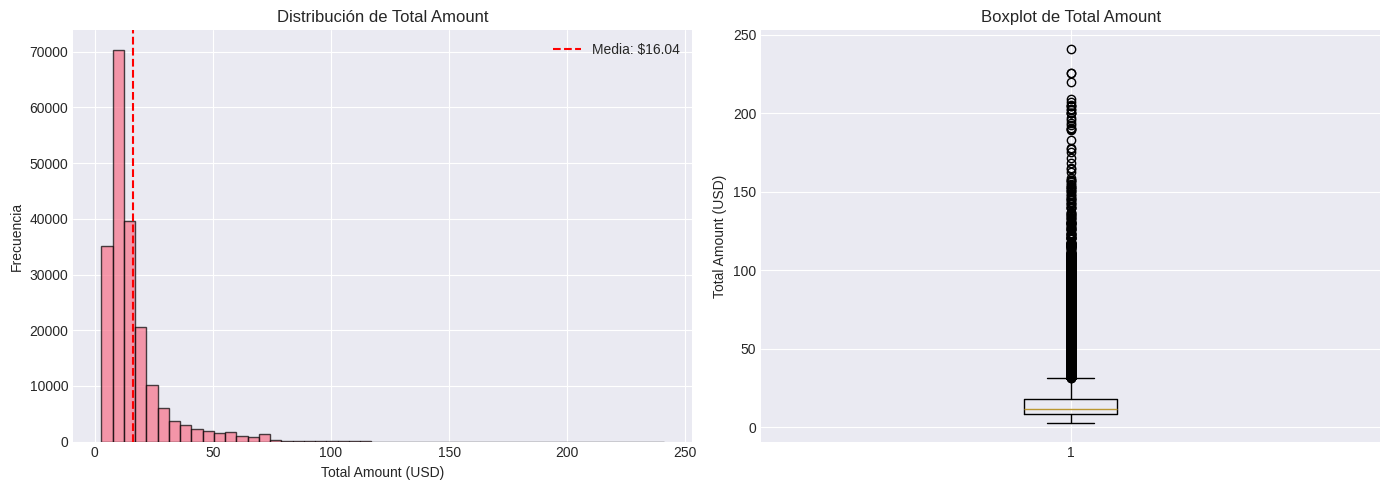


📈 Total Amount promedio por año-mes:
    YEAR  MONTH  TOTAL_AMOUNT
0   2015      1     14.994453
1   2015      2     15.049918
2   2015      3     15.559506
3   2015      4     15.429609
4   2015      5     16.181510
5   2015      6     16.009628
6   2015      7     15.702403
7   2015      8     15.961601
8   2015      9     16.387345
9   2015     10     15.764988
10  2015     11     16.050869
11  2015     12     15.938749
12  2016      1     15.597712
13  2016      2     15.172213
14  2016      3     15.465410
15  2016      4     15.860725
16  2016      5     16.216630
17  2016      6     16.592141
18  2016      7     16.083644
19  2016      8     15.888413
20  2016      9     16.354861
21  2016     10     16.128164
22  2016     11     16.359789
23  2016     12     15.966335
24  2017      1     15.409959
25  2017      2     15.503481
26  2017      3     16.013416
27  2017      4     16.048099
28  2017      5     16.858529
29  2017      6     16.284714
30  2017      7     16.309606
31

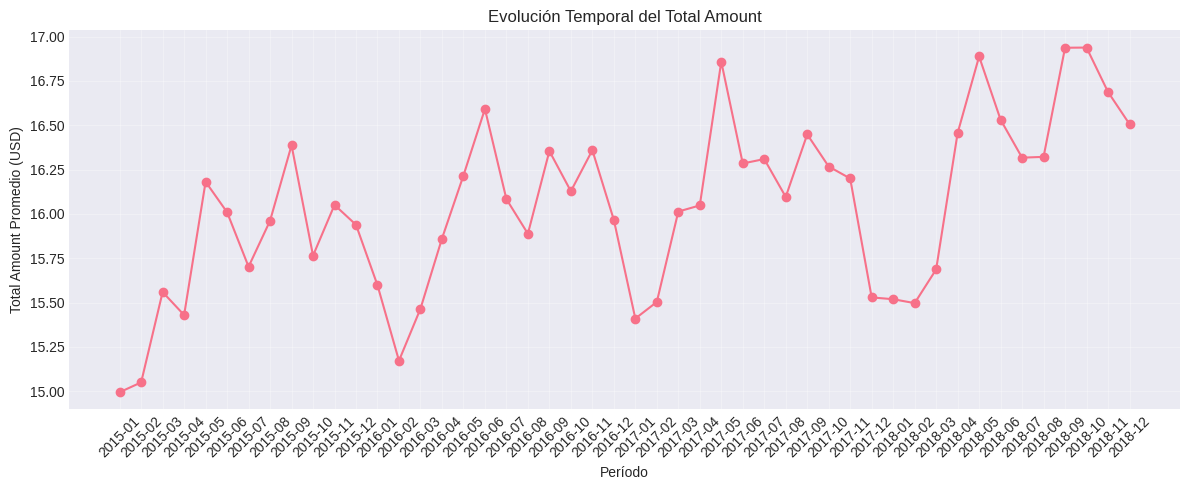


🔗 Correlaciones con TOTAL_AMOUNT:
TOTAL_AMOUNT       1.000000
TRIP_DISTANCE      0.931061
MONTH              0.019532
PICKUP_HOUR        0.011133
PASSENGER_COUNT    0.010677
DAY_OF_WEEK       -0.011877
Name: TOTAL_AMOUNT, dtype: float64

📍 Top 10 zonas de pickup (PU_BOROUGH):
PU_BOROUGH
Manhattan        170119
Queens            16195
Brooklyn           9882
Unknown            2547
Bronx              1159
Staten Island         7
EWR                   6
Name: count, dtype: int64

🚕 Distribución de SERVICE_TYPE:
SERVICE_TYPE
yellow    180118
green      19850
Name: count, dtype: int64


In [7]:

print("\n" + "="*80)
print("ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
print("="*80)

# Estadísticas del target
print("\n Estadísticas de TOTAL_AMOUNT:")
print(datos['TOTAL_AMOUNT'].describe())

# Visualización del target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(datos['TOTAL_AMOUNT'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Amount (USD)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Total Amount')
axes[0].axvline(datos['TOTAL_AMOUNT'].mean(), color='red', linestyle='--', label=f'Media: ${datos["TOTAL_AMOUNT"].mean():.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(datos['TOTAL_AMOUNT'])
axes[1].set_ylabel('Total Amount (USD)')
axes[1].set_title('Boxplot de Total Amount')

plt.tight_layout()
plt.savefig('evidencias/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Distribución temporal
print("\n📈 Total Amount promedio por año-mes:")
temp_avg = datos.groupby(['YEAR', 'MONTH'])['TOTAL_AMOUNT'].mean().reset_index()
print(temp_avg)

# Visualización temporal
plt.figure(figsize=(12, 5))
temp_avg['periodo'] = temp_avg['YEAR'].astype(str) + '-' + temp_avg['MONTH'].astype(str).str.zfill(2)
plt.plot(temp_avg['periodo'], temp_avg['TOTAL_AMOUNT'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Período')
plt.ylabel('Total Amount Promedio (USD)')
plt.title('Evolución Temporal del Total Amount')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('evidencias/02_temporal_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlaciones con features numéricas
print("\n🔗 Correlaciones con TOTAL_AMOUNT:")
numeric_cols = ['TRIP_DISTANCE', 'PASSENGER_COUNT', 'PICKUP_HOUR', 'DAY_OF_WEEK', 'MONTH']
correlaciones = datos[numeric_cols + ['TOTAL_AMOUNT']].corr()['TOTAL_AMOUNT'].sort_values(ascending=False)
print(correlaciones)

# Top features categóricas
print("\nTop 10 zonas de pickup (PU_BOROUGH):")
print(datos['PU_BOROUGH'].value_counts().head(10))

print("\ Distribución de SERVICE_TYPE:")
print(datos['SERVICE_TYPE'].value_counts())

## FEATURE ENGINEERING Y PREPARACIÓN

In [8]:
print("\n" + "="*80)
print("FEATURE ENGINEERING (SIN DATA LEAKAGE)")
print("="*80)

# Crear copia para trabajar
df = datos.copy()

# Features temporales adicionales
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([1, 7]).astype(int)  # Domingo=1, Sábado=7
df['IS_RUSH_HOUR'] = df['PICKUP_HOUR'].isin([7, 8, 9, 17, 18, 19]).astype(int)
df['HOUR_SIN'] = np.sin(2 * np.pi * df['PICKUP_HOUR'] / 24)
df['HOUR_COS'] = np.cos(2 * np.pi * df['PICKUP_HOUR'] / 24)

# Controlar cardinalidad de zonas (Top-K + "Other")
TOP_K_ZONES = 50
top_zones = df['PU_ZONE'].value_counts().head(TOP_K_ZONES).index
df['PU_ZONE_GROUPED'] = df['PU_ZONE'].apply(lambda x: x if x in top_zones else 'OTHER')

# Rellenar nulos en categóricas
for col in ['PU_BOROUGH', 'PU_SERVICE_ZONE', 'SERVICE_TYPE', 'STORE_AND_FWD_FLAG']:
    df[col] = df[col].fillna('UNKNOWN')

# Rellenar nulos en numéricas
df['PASSENGER_COUNT'] = df['PASSENGER_COUNT'].fillna(1)  # Asumir 1 pasajero si falta

print("✅ Feature engineering completado")
print(f"   Features totales: {df.shape[1]}")


FEATURE ENGINEERING (SIN DATA LEAKAGE)
✅ Feature engineering completado
   Features totales: 22


## SPLIT TEMPORAL (TRAIN / VALIDATION / TEST) - 

In [9]:
print("\n" + "="*80)
print("SPLIT TEMPORAL DE DATOS")
print("="*80)

# Verificar los años disponibles en el dataset
años_disponibles = sorted(df['YEAR'].unique())
print(f"📅 Años disponibles en el dataset: {años_disponibles}")

# Estrategia de split temporal
if len(años_disponibles) >= 3:
    # Si tenemos 3+ años: Train (más antiguos), Validation (intermedio), Test (más reciente)
    años_train = años_disponibles[:-2]
    año_val = años_disponibles[-2]
    año_test = años_disponibles[-1]
    
    train_mask = df['YEAR'].isin(años_train)
    val_mask = df['YEAR'] == año_val
    test_mask = df['YEAR'] == año_test
    
    print(f"✅ Estrategia: Múltiples años")
    print(f"   Train: {años_train}")
    print(f"   Validation: {año_val}")
    print(f"   Test: {año_test}")

# Aplicar los splits
df_train = df[train_mask].copy()
df_val = df[val_mask].copy()
df_test = df[test_mask].copy()

# Verificar que no hay solapamiento de fechas
fechas_train = df_train['PICKUP_DATETIME']
fechas_val = df_val['PICKUP_DATETIME'] 
fechas_test = df_test['PICKUP_DATETIME']

print(f"\n📊 DISTRIBUCIÓN TEMPORAL:")
print(f"   Train:      {len(df_train):>8,} filas ({fechas_train.min().date()} a {fechas_train.max().date()})")
print(f"   Validation: {len(df_val):>8,} filas ({fechas_val.min().date()} a {fechas_val.max().date()})")
print(f"   Test:       {len(df_test):>8,} filas ({fechas_test.min().date()} a {fechas_test.max().date()})")

# Verificar distribución del target
print(f"\n💰 DISTRIBUCIÓN DEL TARGET (TOTAL_AMOUNT):")
print(f"   Global:     ${df['TOTAL_AMOUNT'].mean():.2f} ± ${df['TOTAL_AMOUNT'].std():.2f}")
print(f"   Train:      ${df_train['TOTAL_AMOUNT'].mean():.2f} ± ${df_train['TOTAL_AMOUNT'].std():.2f}")
print(f"   Validation: ${df_val['TOTAL_AMOUNT'].mean():.2f} ± ${df_val['TOTAL_AMOUNT'].std():.2f}")
print(f"   Test:       ${df_test['TOTAL_AMOUNT'].mean():.2f} ± ${df_test['TOTAL_AMOUNT'].std():.2f}")

# Verificar proporciones
total_filas = len(df_train) + len(df_val) + len(df_test)
print(f"\n📈 PROPORCIONES:")
print(f"   Train:      {len(df_train)/total_filas:.1%} ({len(df_train):,} filas)")
print(f"   Validation: {len(df_val)/total_filas:.1%} ({len(df_val):,} filas)")
print(f"   Test:       {len(df_test)/total_filas:.1%} ({len(df_test):,} filas)")

# Verificar que no hay solapamiento temporal
print(f"\n🔍 VERIFICACIÓN DE SOLAPAMIENTO:")
max_train = df_train['PICKUP_DATETIME'].max()
min_val = df_val['PICKUP_DATETIME'].min()
max_val = df_val['PICKUP_DATETIME'].max() 
min_test = df_test['PICKUP_DATETIME'].min()

if max_train < min_val and max_val < min_test:
    print("   ✅ No hay solapamiento temporal entre conjuntos")
else:
    print("   ⚠️  Advertencia: Posible solapamiento temporal detectado")

# FEATURES Y TARGET
print(f"\n🎯 DEFINICIÓN DE FEATURES Y TARGET:")

features_numericas = [
    'TRIP_DISTANCE', 'PASSENGER_COUNT', 'PICKUP_HOUR', 'DAY_OF_WEEK', 
    'MONTH', 'IS_WEEKEND', 'IS_RUSH_HOUR', 'HOUR_SIN', 'HOUR_COS'
]

features_categoricas = [
    'PU_ZONE_GROUPED', 'PU_BOROUGH', 'PU_SERVICE_ZONE',
    'SERVICE_TYPE', 'VENDOR_ID', 'RATE_CODE_ID', 
    'PAYMENT_TYPE', 'STORE_AND_FWD_FLAG'
]

target = 'TOTAL_AMOUNT'

# Verificar que todas las features existen en el DataFrame
features_totales = features_numericas + features_categoricas
features_faltantes = [f for f in features_totales if f not in df.columns]

if features_faltantes:
    print(f"   ⚠️  Features faltantes: {features_faltantes}")
    # Remover features faltantes
    features_numericas = [f for f in features_numericas if f in df.columns]
    features_categoricas = [f for f in features_categoricas if f in df.columns]
    features_totales = features_numericas + features_categoricas

print(f"   ✅ Features numéricas:  {len(features_numericas)}")
print(f"   ✅ Features categóricas: {len(features_categoricas)}")
print(f"   ✅ Total features:       {len(features_totales)}")
print(f"   ✅ Target:               {target}")

# Crear conjuntos X, y
X_train = df_train[features_totales]
y_train = df_train[target]

X_val = df_val[features_totales] 
y_val = df_val[target]

X_test = df_test[features_totales]
y_test = df_test[target]

print(f"\n SPLIT TEMPORAL COMPLETADO EXITOSAMENTE!")
print(f"   Los conjuntos están listos para el preprocesamiento y modelado.")


SPLIT TEMPORAL DE DATOS
📅 Años disponibles en el dataset: [2015, 2016, 2017, 2018]
✅ Estrategia: Múltiples años
   Train: [2015, 2016]
   Validation: 2017
   Test: 2018

📊 DISTRIBUCIÓN TEMPORAL:
   Train:        99,984 filas (2015-01-01 a 2016-12-31)
   Validation:   49,992 filas (2017-01-01 a 2017-12-31)
   Test:         49,992 filas (2018-01-01 a 2018-12-31)

💰 DISTRIBUCIÓN DEL TARGET (TOTAL_AMOUNT):
   Global:     $16.04 ± $13.13
   Train:      $15.86 ± $12.76
   Validation: $16.08 ± $13.29
   Test:       $16.36 ± $13.66

📈 PROPORCIONES:
   Train:      50.0% (99,984 filas)
   Validation: 25.0% (49,992 filas)
   Test:       25.0% (49,992 filas)

🔍 VERIFICACIÓN DE SOLAPAMIENTO:
   ✅ No hay solapamiento temporal entre conjuntos

🎯 DEFINICIÓN DE FEATURES Y TARGET:
   ✅ Features numéricas:  9
   ✅ Features categóricas: 8
   ✅ Total features:       17
   ✅ Target:               TOTAL_AMOUNT

🎉 SPLIT TEMPORAL COMPLETADO EXITOSAMENTE!
   Los conjuntos están listos para el preprocesamiento 

## Preprocesamiento

In [10]:

print("\n" + "="*80)
print("PREPROCESAMIENTO CON PIPELINES - CORREGIDO")
print("="*80)

# Asegurar que las columnas categóricas sean string para evitar problemas de tipo
for col in features_categoricas:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Codificar categóricas con LabelEncoder, manejando valores nuevos
le_dict = {}
for col in features_categoricas:
    # Antes de fit, aseguramos que 'UNKNOWN' esté presente en los datos de entrenamiento
    # para que el encoder lo maneje. Si no está, lo añadimos temporalmente solo para el fit.
    unique_train_values = set(X_train[col].unique())
    if 'UNKNOWN' not in unique_train_values:
        # Creamos un encoder que incluya 'UNKNOWN' como una clase válida, aunque no esté en X_train
        # Concatenamos 'UNKNOWN' a las clases únicas de train para el fit
        temp_series_for_fit = pd.concat([X_train[col], pd.Series(['UNKNOWN'])]).drop_duplicates().reset_index(drop=True)
        le = LabelEncoder()
        le.fit(temp_series_for_fit) # Ahora 'UNKNOWN' tiene un código (el último, o el que le toque según orden)
    else:
        le = LabelEncoder()
        le.fit(X_train[col]) # 'UNKNOWN' ya está en las clases aprendidas

    # Función para reemplazar valores no vistos en train con 'UNKNOWN'
    def replace_unseen(series, known_classes):
        known_set = set(known_classes)
        return series.apply(lambda x: x if x in known_set else 'UNKNOWN')

    # Aplicar reemplazo de valores no vistos en VAL y TEST
    X_val[col] = replace_unseen(X_val[col], le.classes_)
    X_test[col] = replace_unseen(X_test[col], le.classes_)

    # Transformar usando el encoder entrenado en train (y 'UNKNOWN' si se añadió)
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col]) # Ahora no debería haber unseen labels
    X_test[col] = le.transform(X_test[col]) # Ahora no debería haber unseen labels

    # Guardar el encoder para esta columna
    le_dict[col] = le

print("✅ Encoding de categóricas completado (valores nuevos manejados como 'UNKNOWN')")

# Escalado (solo para modelos que lo requieren como KNN, Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("✅ Escalado completado")


PREPROCESAMIENTO CON PIPELINES - CORREGIDO
✅ Encoding de categóricas completado (valores nuevos manejados como 'UNKNOWN')
✅ Escalado completado



# *Proceso de Entrenamiento, Selección y Comparación de Modelos*

Cada modelo entrenado en el experimento incluye *su propia búsqueda de hiperparámetros (GridSearch)*, definida específicamente para su arquitectura y comportamiento. Esto significa que LightGBM, XGBoost, CatBoost, AdaBoost, Bagging, Pasting, Voting y los modelos base fueron optimizados de manera independiente, utilizando grids distintos y adecuados para cada familia de algoritmos.

El proceso consiste en:

- Definir un *grid de hiperparámetros* especializado para cada modelo.
- Entrenar múltiples configuraciones usando el *split temporal* (train: 2015-ene a 2015-oct, validación: 2015-nov a 2015-dic).
- Seleccionar la *mejor configuración* en función del rendimiento en validación.
- Reentrenar el mejor modelo y evaluarlo finalmente sobre el *conjunto de test 2016*.

Para cada algoritmo se obtiene:

- La *mejor combinación de hiperparámetros* según la métrica primaria.
- *RMSE, MAE y R²* en validación.
- *RMSE, MAE y R²* en test.
- *Tiempo total de entrenamiento* como métrica adicional de eficiencia.
- Comportamiento y estabilidad de sus predicciones.

Finalmente, todos los modelos son reunidos en la *Tabla Comparativa Completa* (Sección 16 del notebook), donde se presenta una evaluación integral bajo un mismo estándar.  
Esta tabla no solo resume los mejores resultados de cada GridSearch, sino que también incluye la:

### *Comparativa de desempeño (validación y test)*
- *RMSE*  
- *MAE*  
- *R²*  
- *Tiempos de entrenamiento y ejecución*

Esta vista consolidada permite identificar de manera clara cuál modelo ofrece *menor error, **mejor capacidad de generalización* y *mayor eficiencia computacional*, determinando así el modelo ganador del experimento.I

##  BASELINE: MEDIA + REGRESIÓN LINEAL

In [11]:
print("\n" + "="*80)
print("MODELOS BASELINE MEJORADOS")
print("="*80)

# Baseline 1: Media del train
print("\n📊 Baseline 1: Predicción con Media")
y_mean = y_train.mean()
y_val_pred_mean = np.full_like(y_val, y_mean)
y_test_pred_mean = np.full_like(y_test, y_mean)

rmse_val_mean = np.sqrt(mean_squared_error(y_val, y_val_pred_mean))
mae_val_mean = mean_absolute_error(y_val, y_val_pred_mean)
r2_val_mean = r2_score(y_val, y_val_pred_mean)

rmse_test_mean = np.sqrt(mean_squared_error(y_test, y_test_pred_mean))
mae_test_mean = mean_absolute_error(y_test, y_test_pred_mean)
r2_test_mean = r2_score(y_test, y_test_pred_mean)

print(f"📊 VALIDACIÓN (Media):")
print(f"   RMSE: ${rmse_val_mean:.4f}")
print(f"   MAE:  ${mae_val_mean:.4f}")
print(f"   R²:   {r2_val_mean:.4f}")

print(f"\n📊 TEST (Media):")
print(f"   RMSE: ${rmse_test_mean:.4f}")
print(f"   MAE:  ${mae_test_mean:.4f}")
print(f"   R²:   {r2_test_mean:.4f}")

# Regresión Lineal
print("\n📊 Baseline 2: Regresión Lineal")
baseline_lr = LinearRegression()
baseline_lr.fit(X_train_scaled, y_train)

y_val_pred_lr = baseline_lr.predict(X_val_scaled)
y_test_pred_lr = baseline_lr.predict(X_test_scaled)

rmse_val_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
mae_val_lr = mean_absolute_error(y_val, y_val_pred_lr)
r2_val_lr = r2_score(y_val, y_val_pred_lr)

rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

print(f"📊 VALIDACIÓN (Linear):")
print(f"   RMSE: ${rmse_val_lr:.4f}")
print(f"   MAE:  ${mae_val_lr:.4f}")
print(f"   R²:   {r2_val_lr:.4f}")

print(f"\n📊 TEST (Linear):")
print(f"   RMSE: ${rmse_test_lr:.4f}")
print(f"   MAE:  ${mae_test_lr:.4f}")
print(f"   R²:   {r2_test_lr:.4f}")


MODELOS BASELINE MEJORADOS

📊 Baseline 1: Predicción con Media
📊 VALIDACIÓN (Media):
   RMSE: $13.2944
   MAE:  $8.4130
   R²:   -0.0003

📊 TEST (Media):
   RMSE: $13.6726
   MAE:  $8.6095
   R²:   -0.0013

📊 Baseline 2: Regresión Lineal
📊 VALIDACIÓN (Linear):
   RMSE: $4.3402
   MAE:  $2.3724
   R²:   0.8934

📊 TEST (Linear):
   RMSE: $4.5662
   MAE:  $2.4276
   R²:   0.8883


## Voting regressor

In [12]:
print("\n" + "="*80)
print("VOTING REGRESSOR")
print("="*80)

# Modelos base para voting
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
rf_voting = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
gbdt_voting = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=RANDOM_STATE)

voting_reg = VotingRegressor([
    ('ridge', ridge),
    ('rf', rf_voting),
    ('gbdt', gbdt_voting)
])

print("🔄 Entrenando Voting Regressor...")
start = time.time()
voting_reg.fit(X_train_scaled, y_train)
tiempo_voting = time.time() - start

y_val_pred_voting = voting_reg.predict(X_val_scaled)
y_test_pred_voting = voting_reg.predict(X_test_scaled)

rmse_val_voting = np.sqrt(mean_squared_error(y_val, y_val_pred_voting))
mae_val_voting = mean_absolute_error(y_val, y_val_pred_voting)
r2_val_voting = r2_score(y_val, y_val_pred_voting)

rmse_test_voting = np.sqrt(mean_squared_error(y_test, y_test_pred_voting))
mae_test_voting = mean_absolute_error(y_test, y_test_pred_voting)
r2_test_voting = r2_score(y_test, y_test_pred_voting)

print(f"✅ Tiempo de entrenamiento: {tiempo_voting:.2f}s")
print(f"\n📊 VALIDACIÓN:")
print(f"   RMSE: ${rmse_val_voting:.4f}")
print(f"   MAE:  ${mae_val_voting:.4f}")
print(f"   R²:   {r2_val_voting:.4f}")

print(f"\n📊 TEST:")
print(f"   RMSE: ${rmse_test_voting:.4f}")
print(f"   MAE:  ${mae_test_voting:.4f}")
print(f"   R²:   {r2_test_voting:.4f}")


VOTING REGRESSOR
🔄 Entrenando Voting Regressor...
✅ Tiempo de entrenamiento: 7.78s

📊 VALIDACIÓN:
   RMSE: $3.4375
   MAE:  $1.9592
   R²:   0.9331

📊 TEST:
   RMSE: $3.7113
   MAE:  $2.0228
   R²:   0.9262


## ENSAMBLES: BAGGING VS PASTING

In [13]:
print("\n" + "="*80)
print("BAGGING VS PASTING")
print("="*80)

# Base learner
base_tree = DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE)

# Bagging (bootstrap=True)
print("\n🌳 Bagging Regressor...")
bagging = BaggingRegressor(
    estimator=base_tree,
    n_estimators=50,
    max_samples=0.8,
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start = time.time()
bagging.fit(X_train, y_train)
tiempo_bagging = time.time() - start

y_val_pred_bagging = bagging.predict(X_val)
y_test_pred_bagging = bagging.predict(X_test)

rmse_val_bagging = np.sqrt(mean_squared_error(y_val, y_val_pred_bagging))
mae_val_bagging = mean_absolute_error(y_val, y_val_pred_bagging)
r2_val_bagging = r2_score(y_val, y_val_pred_bagging)

rmse_test_bagging = np.sqrt(mean_squared_error(y_test, y_test_pred_bagging))
mae_test_bagging = mean_absolute_error(y_test, y_test_pred_bagging)
r2_test_bagging = r2_score(y_test, y_test_pred_bagging)

print(f"✅ Tiempo: {tiempo_bagging:.2f}s")
print(f"   VAL RMSE: ${rmse_val_bagging:.4f}, MAE: ${mae_val_bagging:.4f}, R²: {r2_val_bagging:.4f}")
print(f"   TEST RMSE: ${rmse_test_bagging:.4f}, MAE: ${mae_test_bagging:.4f}, R²: {r2_test_bagging:.4f}")

# Pasting (bootstrap=False)
print("\n📋 Pasting Regressor...")
pasting = BaggingRegressor(
    estimator=base_tree,
    n_estimators=50,
    max_samples=0.8,
    bootstrap=False,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start = time.time()
pasting.fit(X_train, y_train)
tiempo_pasting = time.time() - start

y_val_pred_pasting = pasting.predict(X_val)
y_test_pred_pasting = pasting.predict(X_test)

rmse_val_pasting = np.sqrt(mean_squared_error(y_val, y_val_pred_pasting))
mae_val_pasting = mean_absolute_error(y_val, y_val_pred_pasting)
r2_val_pasting = r2_score(y_val, y_val_pred_pasting)

rmse_test_pasting = np.sqrt(mean_squared_error(y_test, y_test_pred_pasting))
mae_test_pasting = mean_absolute_error(y_test, y_test_pred_pasting)
r2_test_pasting = r2_score(y_test, y_test_pred_pasting)

print(f"✅ Tiempo: {tiempo_pasting:.2f}s")
print(f"   VAL RMSE: ${rmse_val_pasting:.4f}, MAE: ${mae_val_pasting:.4f}, R²: {r2_val_pasting:.4f}")
print(f"   TEST RMSE: ${rmse_test_pasting:.4f}, MAE: ${mae_test_pasting:.4f}, R²: {r2_test_pasting:.4f}")


BAGGING VS PASTING

🌳 Bagging Regressor...
✅ Tiempo: 4.19s
   VAL RMSE: $3.3491, MAE: $1.8951, R²: 0.9365
   TEST RMSE: $3.7346, MAE: $1.9783, R²: 0.9253

📋 Pasting Regressor...
✅ Tiempo: 3.33s
   VAL RMSE: $3.3704, MAE: $1.9064, R²: 0.9357
   TEST RMSE: $3.7917, MAE: $1.9927, R²: 0.9230


## ADABOOST

In [14]:
print("\n" + "="*80)
print("ADABOOST REGRESSOR CON TIMESERIESSPLIT")
print("="*80)

# Búsqueda de hiperparámetros
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

ada_base = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    random_state=RANDOM_STATE
)

print("🔍 Grid Search para AdaBoost con TimeSeriesSplit...")
grid_ada = GridSearchCV(
    ada_base,
    param_grid_ada,
    cv=tscv,  # TimeSeriesSpli
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

start = time.time()
grid_ada.fit(X_train, y_train)
tiempo_ada = time.time() - start

print(f"✅ Mejores parámetros: {grid_ada.best_params_}")
print(f"   Mejor RMSE (CV): ${-grid_ada.best_score_:.4f}")
print(f"   Tiempo: {tiempo_ada:.2f}s")

ada_best = grid_ada.best_estimator_

y_val_pred_ada = ada_best.predict(X_val)
y_test_pred_ada = ada_best.predict(X_test)

rmse_val_ada = np.sqrt(mean_squared_error(y_val, y_val_pred_ada))
mae_val_ada = mean_absolute_error(y_val, y_val_pred_ada)
r2_val_ada = r2_score(y_val, y_val_pred_ada)

rmse_test_ada = np.sqrt(mean_squared_error(y_test, y_test_pred_ada))
mae_test_ada = mean_absolute_error(y_test, y_test_pred_ada)
r2_test_ada = r2_score(y_test, y_test_pred_ada)

print(f"\n📊 VALIDACIÓN:")
print(f"   RMSE: ${rmse_val_ada:.4f}")
print(f"   MAE:  ${mae_val_ada:.4f}")
print(f"   R²:   {r2_val_ada:.4f}")

print(f"\n📊 TEST:")
print(f"   RMSE: ${rmse_test_ada:.4f}")
print(f"   MAE:  ${mae_test_ada:.4f}")
print(f"   R²:   {r2_test_ada:.4f}")


ADABOOST REGRESSOR CON TIMESERIESSPLIT
🔍 Grid Search para AdaBoost con TimeSeriesSplit...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Mejores parámetros: {'learning_rate': 0.1, 'n_estimators': 50}
   Mejor RMSE (CV): $4.7741
   Tiempo: 96.09s

📊 VALIDACIÓN:
   RMSE: $4.6390
   MAE:  $3.1157
   R²:   0.8782

📊 TEST:
   RMSE: $4.8062
   MAE:  $3.1429
   R²:   0.8763


## GRADIENT BOOSTING (GBDT)

In [15]:

print("\n" + "="*80)
print("GRADIENT BOOSTING REGRESSOR CON TIMESERIESSPLIT")
print("="*80)

param_grid_gbdt = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gbdt = GradientBoostingRegressor(random_state=RANDOM_STATE)

print("🔍 Randomized Search para GBDT con TimeSeriesSplit...")
random_gbdt = RandomizedSearchCV(
    gbdt,
    param_grid_gbdt,
    n_iter=10,
    cv=tscv,  # ¡MEJORA CRÍTICA: TimeSeriesSplit!
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

start = time.time()
random_gbdt.fit(X_train, y_train)
tiempo_gbdt = time.time() - start

print(f"✅ Mejores parámetros: {random_gbdt.best_params_}")
print(f"   Mejor RMSE (CV): ${-random_gbdt.best_score_:.4f}")
print(f"   Tiempo: {tiempo_gbdt:.2f}s")

gbdt_best = random_gbdt.best_estimator_

y_val_pred_gbdt = gbdt_best.predict(X_val)
y_test_pred_gbdt = gbdt_best.predict(X_test)

rmse_val_gbdt = np.sqrt(mean_squared_error(y_val, y_val_pred_gbdt))
mae_val_gbdt = mean_absolute_error(y_val, y_val_pred_gbdt)
r2_val_gbdt = r2_score(y_val, y_val_pred_gbdt)

rmse_test_gbdt = np.sqrt(mean_squared_error(y_test, y_test_pred_gbdt))
mae_test_gbdt = mean_absolute_error(y_test, y_test_pred_gbdt)
r2_test_gbdt = r2_score(y_test, y_test_pred_gbdt)

print(f"\n📊 VALIDACIÓN:")
print(f"   RMSE: ${rmse_val_gbdt:.4f}")
print(f"   MAE:  ${mae_val_gbdt:.4f}")
print(f"   R²:   {r2_val_gbdt:.4f}")

print(f"\n📊 TEST:")
print(f"   RMSE: ${rmse_test_gbdt:.4f}")
print(f"   MAE:  ${mae_test_gbdt:.4f}")
print(f"   R²:   {r2_test_gbdt:.4f}")


GRADIENT BOOSTING REGRESSOR CON TIMESERIESSPLIT
🔍 Randomized Search para GBDT con TimeSeriesSplit...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Mejores parámetros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
   Mejor RMSE (CV): $3.3292
   Tiempo: 68.21s

📊 VALIDACIÓN:
   RMSE: $3.1155
   MAE:  $1.7838
   R²:   0.9451

📊 TEST:
   RMSE: $3.5490
   MAE:  $1.8535
   R²:   0.9325


## XGBOOST

In [16]:
print("\n" + "="*80)
print("XGBOOST REGRESSOR CON TIMESERIESSPLIT (EXTREME GRADIENT BOOSTING)")
print("="*80)

# Grid más exhaustivo para XGBoost (nuestro modelo asignado)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]     # L2 regularization
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("🔍 Randomized Search para XGBoost con TimeSeriesSplit...")
random_xgb = RandomizedSearchCV(
    xgb_model,
    param_grid_xgb,
    n_iter=20,
    cv=tscv,  # TimeSeriesSplit!
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

start = time.time()
random_xgb.fit(X_train, y_train)
tiempo_xgb = time.time() - start

print(f"\n✅ Mejores parámetros XGBoost:")
for param, value in random_xgb.best_params_.items():
    print(f"   {param}: {value}")
print(f"   Mejor RMSE (CV): ${-random_xgb.best_score_:.4f}")
print(f"   Tiempo total: {tiempo_xgb:.2f}s ({tiempo_xgb/60:.2f} min)")

xgb_best = random_xgb.best_estimator_

y_val_pred_xgb = xgb_best.predict(X_val)
y_test_pred_xgb = xgb_best.predict(X_test)

rmse_val_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
mae_val_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
r2_val_xgb = r2_score(y_val, y_val_pred_xgb)

rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"\n📊 VALIDACIÓN:")
print(f"   RMSE: ${rmse_val_xgb:.4f}")
print(f"   MAE:  ${mae_val_xgb:.4f}")
print(f"   R²:   {r2_val_xgb:.4f}")

print(f"\n📊 TEST:")
print(f"   RMSE: ${rmse_test_xgb:.4f}")
print(f"   MAE:  ${mae_test_xgb:.4f}")
print(f"   R²:   {r2_test_xgb:.4f}")

# Importancia de features en XGBoost
print("\n🎯 Top 10 Features más importantes (XGBoost):")
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_xgb.head(10))


XGBOOST REGRESSOR CON TIMESERIESSPLIT (EXTREME GRADIENT BOOSTING)
🔍 Randomized Search para XGBoost con TimeSeriesSplit...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Mejores parámetros XGBoost:
   subsample: 1.0
   reg_lambda: 1
   reg_alpha: 0.1
   n_estimators: 300
   min_child_weight: 5
   max_depth: 3
   learning_rate: 0.1
   colsample_bytree: 0.8
   Mejor RMSE (CV): $3.3844
   Tiempo total: 12.33s (0.21 min)

📊 VALIDACIÓN:
   RMSE: $3.2963
   MAE:  $1.8364
   R²:   0.9385

📊 TEST:
   RMSE: $3.6482
   MAE:  $1.9065
   R²:   0.9287

🎯 Top 10 Features más importantes (XGBoost):
            feature  importance
0     TRIP_DISTANCE    0.576603
11  PU_SERVICE_ZONE    0.115833
14     RATE_CODE_ID    0.099417
15     PAYMENT_TYPE    0.087055
12     SERVICE_TYPE    0.065088
8          HOUR_COS    0.009298
2       PICKUP_HOUR    0.009185
13        VENDOR_ID    0.008875
3       DAY_OF_WEEK    0.006371
10       PU_BOROUGH    0.006112


## LIGHTGBM

In [17]:
print("\n" + "="*80)
print("LIGHTGBM REGRESSOR CON TIMESERIESSPLIT")
print("="*80)

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [5, 7, -1],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9],
    'bagging_freq': [5],
    'lambda_l1': [0, 0.1],
    'lambda_l2': [0, 0.1]
}

lgbm_model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

print("🔍 Randomized Search para LightGBM con TimeSeriesSplit...")
random_lgbm = RandomizedSearchCV(
    lgbm_model,
    param_grid_lgbm,
    n_iter=15,
    cv=tscv,  # TimeSeriesSplit!
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

start = time.time()
random_lgbm.fit(X_train, y_train)
tiempo_lgbm = time.time() - start

print(f"✅ Mejores parámetros: {random_lgbm.best_params_}")
print(f"   Mejor RMSE (CV): ${-random_lgbm.best_score_:.4f}")
print(f"   Tiempo: {tiempo_lgbm:.2f}s")

lgbm_best = random_lgbm.best_estimator_

y_val_pred_lgbm = lgbm_best.predict(X_val)
y_test_pred_lgbm = lgbm_best.predict(X_test)

rmse_val_lgbm = np.sqrt(mean_squared_error(y_val, y_val_pred_lgbm))
mae_val_lgbm = mean_absolute_error(y_val, y_val_pred_lgbm)
r2_val_lgbm = r2_score(y_val, y_val_pred_lgbm)

rmse_test_lgbm = np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm))
mae_test_lgbm = mean_absolute_error(y_test, y_test_pred_lgbm)
r2_test_lgbm = r2_score(y_test, y_test_pred_lgbm)

print(f"\n📊 VALIDACIÓN:")
print(f"   RMSE: ${rmse_val_lgbm:.4f}")
print(f"   MAE:  ${mae_val_lgbm:.4f}")
print(f"   R²:   {r2_val_lgbm:.4f}")

print(f"\n📊 TEST:")
print(f"   RMSE: ${rmse_test_lgbm:.4f}")
print(f"   MAE:  ${mae_test_lgbm:.4f}")
print(f"   R²:   {r2_test_lgbm:.4f}")


LIGHTGBM REGRESSOR CON TIMESERIESSPLIT
🔍 Randomized Search para LightGBM con TimeSeriesSplit...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Mejores parámetros: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'lambda_l2': 0.1, 'lambda_l1': 0, 'feature_fraction': 0.8, 'bagging_freq': 5, 'bagging_fraction': 0.9}
   Mejor RMSE (CV): $3.3058
   Tiempo: 255.53s

📊 VALIDACIÓN:
   RMSE: $3.2412
   MAE:  $1.8007
   R²:   0.9405

📊 TEST:
   RMSE: $3.5807
   MAE:  $1.8600
   R²:   0.9313


## Catboost

In [18]:
print("\n" + "="*80)
print("CATBOOST REGRESSOR CON TIMESERIESSPLIT")
print("="*80)

# CatBoost maneja categóricas nativamente
# Usar datos originales sin encoding.
X_train_cat = df_train[features_numericas + features_categoricas].copy()
X_val_cat = df_val[features_numericas + features_categoricas].copy()
X_test_cat = df_test[features_numericas + features_categoricas].copy()

# Identificar índices de features categóricas
cat_features_idx = [X_train_cat.columns.get_loc(col) for col in features_categoricas]

param_grid_catboost = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5, 1]
}

catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    random_state=RANDOM_STATE,
    verbose=0,
    cat_features=cat_features_idx
)

print("🔍 Randomized Search para CatBoost con TimeSeriesSplit...")
random_catboost = RandomizedSearchCV(
    catboost_model,
    param_grid_catboost,
    n_iter=10,
    cv=tscv,  # ¡ TimeSeriesSplit!
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

start = time.time()
random_catboost.fit(X_train_cat, y_train)
tiempo_catboost = time.time() - start

print(f"✅ Mejores parámetros: {random_catboost.best_params_}")
print(f"   Mejor RMSE (CV): ${-random_catboost.best_score_:.4f}")
print(f"   Tiempo: {tiempo_catboost:.2f}s")

catboost_best = random_catboost.best_estimator_

y_val_pred_catboost = catboost_best.predict(X_val_cat)
y_test_pred_catboost = catboost_best.predict(X_test_cat)

rmse_val_catboost = np.sqrt(mean_squared_error(y_val, y_val_pred_catboost))
mae_val_catboost = mean_absolute_error(y_val, y_val_pred_catboost)
r2_val_catboost = r2_score(y_val, y_val_pred_catboost)

rmse_test_catboost = np.sqrt(mean_squared_error(y_test, y_test_pred_catboost))
mae_test_catboost = mean_absolute_error(y_test, y_test_pred_catboost)
r2_test_catboost = r2_score(y_test, y_test_pred_catboost)

print(f"\n📊 VALIDACIÓN:")
print(f"   RMSE: ${rmse_val_catboost:.4f}")
print(f"   MAE:  ${mae_val_catboost:.4f}")
print(f"   R²:   {r2_val_catboost:.4f}")

print(f"\n📊 TEST:")
print(f"   RMSE: ${rmse_test_catboost:.4f}")
print(f"   MAE:  ${mae_test_catboost:.4f}")
print(f"   R²:   {r2_test_catboost:.4f}")


CATBOOST REGRESSOR CON TIMESERIESSPLIT
🔍 Randomized Search para CatBoost con TimeSeriesSplit...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Mejores parámetros: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8, 'bagging_temperature': 0}
   Mejor RMSE (CV): $3.4841
   Tiempo: 260.55s

📊 VALIDACIÓN:
   RMSE: $3.3928
   MAE:  $1.8294
   R²:   0.9349

📊 TEST:
   RMSE: $3.8459
   MAE:  $1.9065
   R²:   0.9208


## Tabla comparativa


TABLA COMPARATIVA DE TODOS LOS MODELOS

📊 RESULTADOS ORDENADOS POR RMSE VALIDACIÓN:
           Modelo  RMSE_Val  MAE_Val    R2_Val  RMSE_Test  MAE_Test   R2_Test  Tiempo_Train_s
Gradient Boosting  3.115510 1.783758  0.945067   3.548993  1.853526  0.932535       68.214147
         LightGBM  3.241220 1.800663  0.940544   3.580703  1.859989  0.931324      255.529213
          XGBoost  3.296311 1.836448  0.938506   3.648179  1.906534  0.928712       12.330949
          Bagging  3.349115 1.895100  0.936520   3.734588  1.978294  0.925295        4.193743
          Pasting  3.370415 1.906395  0.935710   3.791673  1.992732  0.922993        3.327339
         CatBoost  3.392768 1.829380  0.934854   3.845882  1.906535  0.920776      260.553113
           Voting  3.437463 1.959157  0.933126   3.711288  2.022844  0.926224        7.783337
Baseline (Linear)  4.340157 2.372428  0.893392   4.566218  2.427603  0.888319        0.000000
         AdaBoost  4.639049 3.115663  0.878203   4.806223  3.142877  

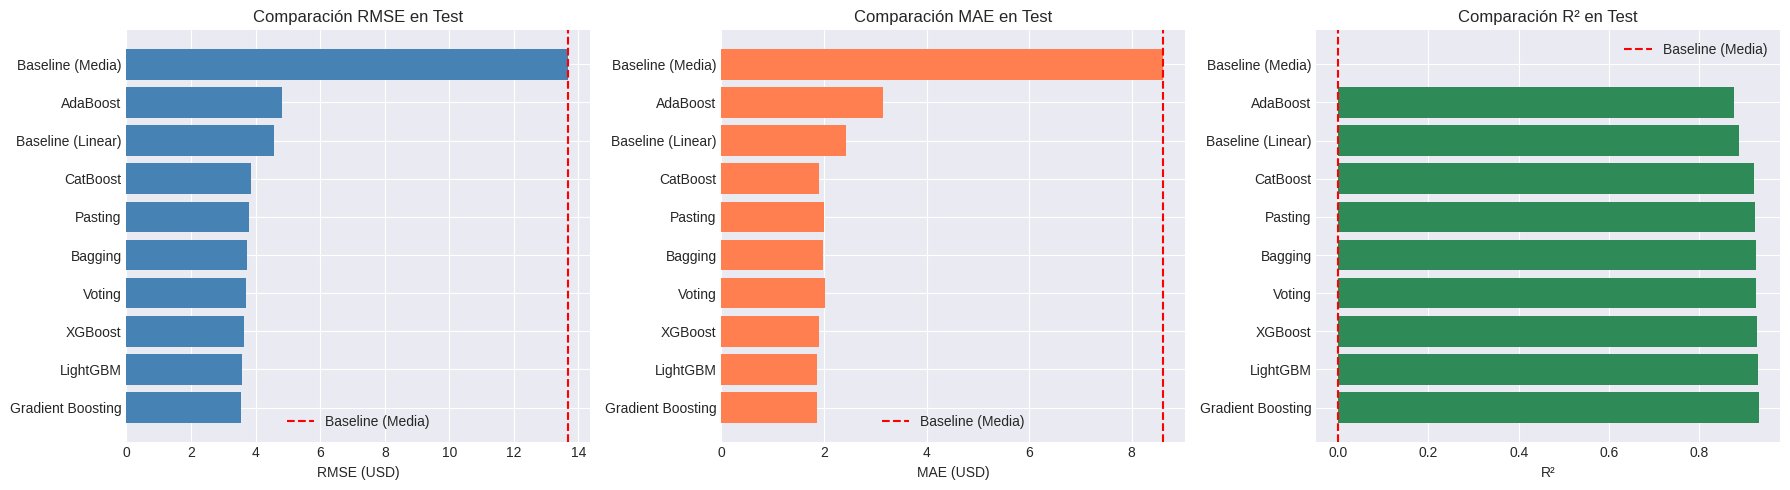


🏆 MEJOR MODELO (por RMSE Validación): Gradient Boosting
   RMSE Test: $3.5490


In [19]:
print("\n" + "="*80)
print("TABLA COMPARATIVA DE TODOS LOS MODELOS")
print("="*80)

resultados = pd.DataFrame({
    'Modelo': [
        'Baseline (Media)',
        'Baseline (Linear)',
        'Voting',
        'Bagging',
        'Pasting',
        'AdaBoost',
        'Gradient Boosting',
        'XGBoost',
        'LightGBM',
        'CatBoost'
    ],
    'RMSE_Val': [
        rmse_val_mean, rmse_val_lr, rmse_val_voting, rmse_val_bagging, rmse_val_pasting,
        rmse_val_ada, rmse_val_gbdt, rmse_val_xgb, rmse_val_lgbm, rmse_val_catboost
    ],
    'MAE_Val': [
        mae_val_mean, mae_val_lr, mae_val_voting, mae_val_bagging, mae_val_pasting,
        mae_val_ada, mae_val_gbdt, mae_val_xgb, mae_val_lgbm, mae_val_catboost
    ],
    'R2_Val': [
        r2_val_mean, r2_val_lr, r2_val_voting, r2_val_bagging, r2_val_pasting,
        r2_val_ada, r2_val_gbdt, r2_val_xgb, r2_val_lgbm, r2_val_catboost
    ],
    'RMSE_Test': [
        rmse_test_mean, rmse_test_lr, rmse_test_voting, rmse_test_bagging, rmse_test_pasting,
        rmse_test_ada, rmse_test_gbdt, rmse_test_xgb, rmse_test_lgbm, rmse_test_catboost
    ],
    'MAE_Test': [
        mae_test_mean, mae_test_lr, mae_test_voting, mae_test_bagging, mae_test_pasting,
        mae_test_ada, mae_test_gbdt, mae_test_xgb, mae_test_lgbm, mae_test_catboost
    ],
    'R2_Test': [
        r2_test_mean, r2_test_lr, r2_test_voting, r2_test_bagging, r2_test_pasting,
        r2_test_ada, r2_test_gbdt, r2_test_xgb, r2_test_lgbm, r2_test_catboost
    ],
    'Tiempo_Train_s': [
        0, 0, tiempo_voting, tiempo_bagging, tiempo_pasting,
        tiempo_ada, tiempo_gbdt, tiempo_xgb, tiempo_lgbm, tiempo_catboost
    ]
})

# Ordenar por RMSE de validación
resultados = resultados.sort_values('RMSE_Val')

print("\n📊 RESULTADOS ORDENADOS POR RMSE VALIDACIÓN:")
print(resultados.to_string(index=False))

# Guardar tabla
resultados.to_csv('evidencias/tabla_comparativa_modelos.csv', index=False)
print("\n✅ Tabla guardada en: evidencias/tabla_comparativa_modelos.csv")

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
resultados_plot = resultados.sort_values('RMSE_Test')
axes[0].barh(resultados_plot['Modelo'], resultados_plot['RMSE_Test'], color='steelblue')
axes[0].set_xlabel('RMSE (USD)')
axes[0].set_title('Comparación RMSE en Test')
axes[0].axvline(rmse_test_mean, color='red', linestyle='--', label='Baseline (Media)')
axes[0].legend()

# MAE
axes[1].barh(resultados_plot['Modelo'], resultados_plot['MAE_Test'], color='coral')
axes[1].set_xlabel('MAE (USD)')
axes[1].set_title('Comparación MAE en Test')
axes[1].axvline(mae_test_mean, color='red', linestyle='--', label='Baseline (Media)')
axes[1].legend()

# R²
axes[2].barh(resultados_plot['Modelo'], resultados_plot['R2_Test'], color='seagreen')
axes[2].set_xlabel('R²')
axes[2].set_title('Comparación R² en Test')
axes[2].axvline(r2_test_mean, color='red', linestyle='--', label='Baseline (Media)')
axes[2].legend()

plt.tight_layout()
plt.savefig('evidencias/03_comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

# Identificar mejor modelo
mejor_modelo_idx = resultados['RMSE_Val'].idxmin()
mejor_modelo_nombre = resultados.loc[mejor_modelo_idx, 'Modelo']
mejor_rmse_test = resultados.loc[mejor_modelo_idx, 'RMSE_Test']

print(f"\n🏆 MEJOR MODELO (por RMSE Validación): {mejor_modelo_nombre}")
print(f"   RMSE Test: ${mejor_rmse_test:.4f}")

## ANÁLISIS DE RESIDUALES (MEJOR MODELO)- Gradient Boosting


ANÁLISIS DE RESIDUALES - Gradient Boosting


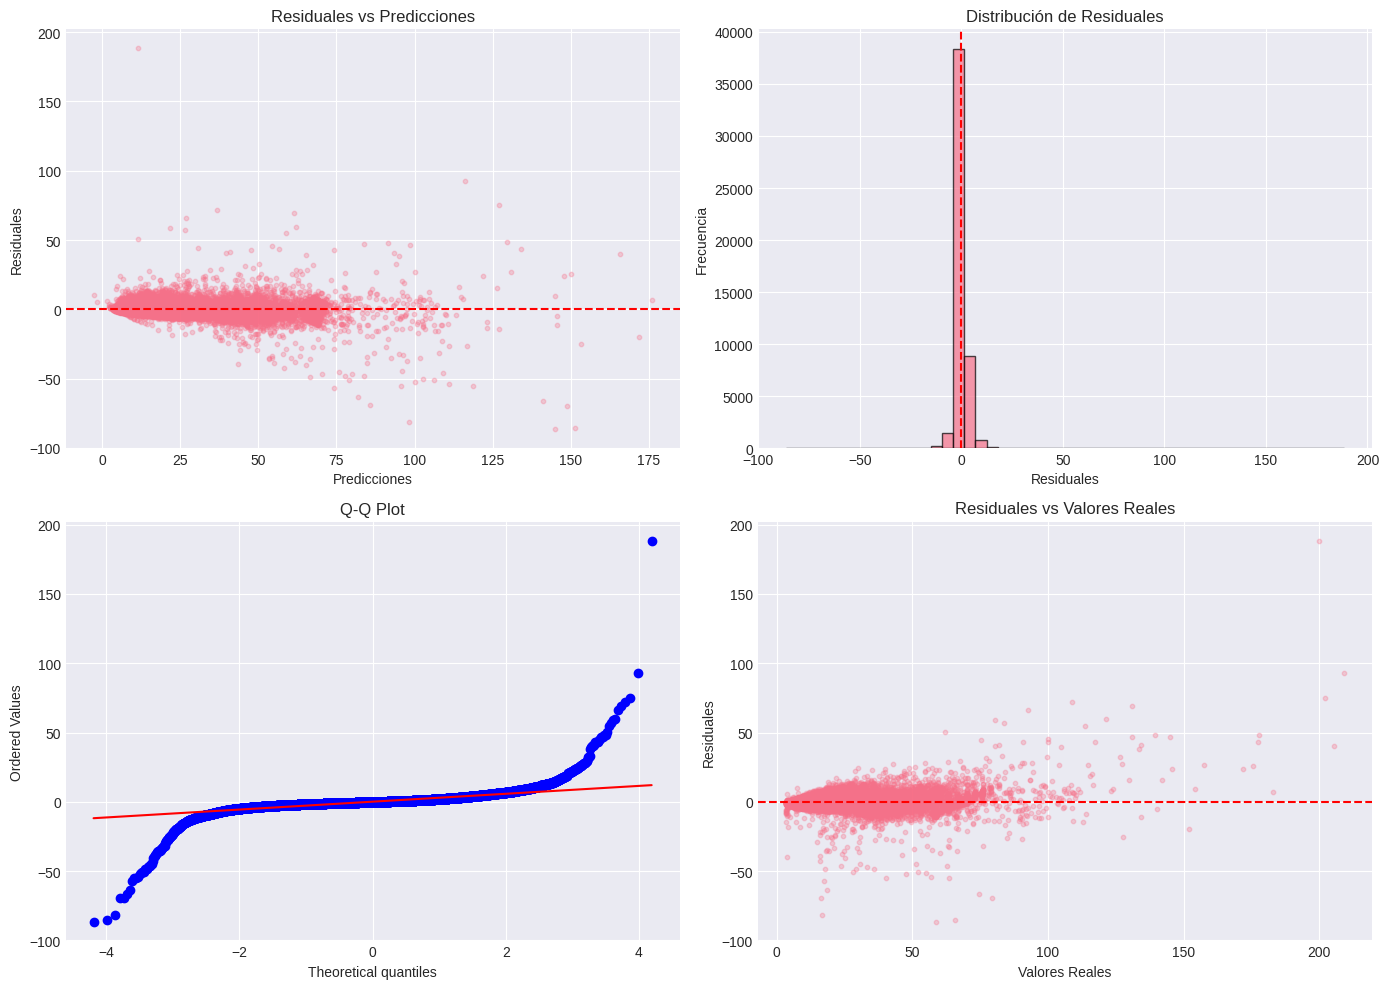


📊 Estadísticas de residuales:
   Media: $0.0814
   Std: $3.5481
   Min: $-86.4551
   Max: $188.3482


In [34]:


print("\n" + "="*80)
print(f"ANÁLISIS DE RESIDUALES - {mejor_modelo_nombre}")
print("="*80)

# Usar predicciones del mejor modelo
residuales_test = y_test - y_test_pred_gbdt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuales vs Predicciones
axes[0, 0].scatter(y_test_pred_gbdt, residuales_test, alpha=0.3, s=10)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicciones')
axes[0, 0].set_ylabel('Residuales')
axes[0, 0].set_title('Residuales vs Predicciones')

# 2. Distribución de residuales
axes[0, 1].hist(residuales_test, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Residuales')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Residuales')

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuales_test, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. Residuales vs Valores reales
axes[1, 1].scatter(y_test, residuales_test, alpha=0.3, s=10)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Valores Reales')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].set_title('Residuales vs Valores Reales')

plt.tight_layout()
plt.savefig('evidencias/04_analisis_residuales.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Estadísticas de residuales:")
print(f"   Media: ${residuales_test.mean():.4f}")
print(f"   Std: ${residuales_test.std():.4f}")
print(f"   Min: ${residuales_test.min():.4f}")
print(f"   Max: ${residuales_test.max():.4f}")

##  ANÁLISIS DE ERROR POR BUCKETS


ANÁLISIS DE ERROR POR BUCKETS

📏 Error por rangos de TRIP_DISTANCE:
                     mean  count
distance_bucket                 
0-2 mi           1.247824  29517
2-5 mi           1.952715  13130
5-10 mi          3.278920   4286
10+ mi           5.275201   3059

🕐 Error por PICKUP_HOUR:
PICKUP_HOUR
14    2.208103
12    2.182645
13    2.151098
17    2.124693
11    2.108451
16    2.100601
15    2.093236
9     2.056856
8     1.990894
10    1.940338
Name: error_absoluto, dtype: float64

📍 Error por PU_BOROUGH:
                    mean  count
PU_BOROUGH                     
EWR            33.289785      4
UNKNOWN        19.423761     11
Bronx           3.587739    285
Queens          3.382467   4094
Staten Island   2.691674      1
Brooklyn        2.508209   1873
Unknown         2.051123    623
Manhattan       1.658103  43101


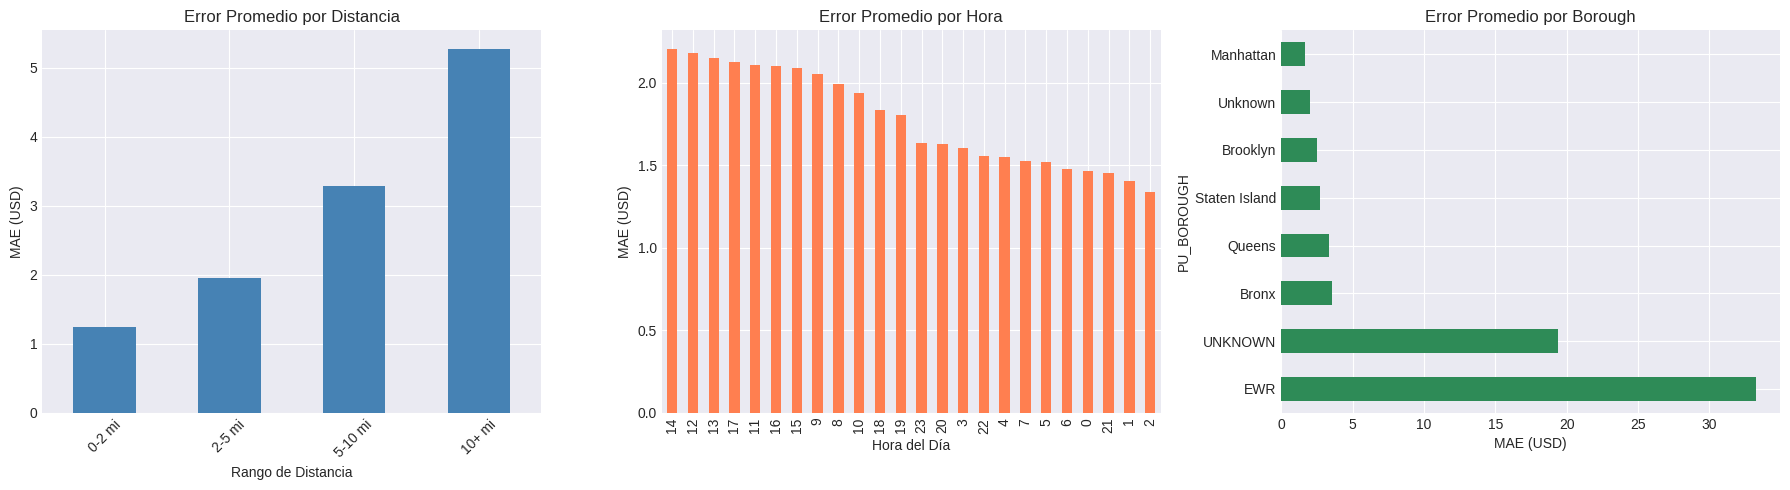

In [35]:
print("\n" + "="*80)
print("ANÁLISIS DE ERROR POR BUCKETS")
print("="*80)

df_test_eval = df_test.copy()
df_test_eval['prediccion'] = y_test_pred_gbdt
df_test_eval['error_absoluto'] = np.abs(y_test - y_test_pred_gbdt)

# Error por distancia
print("\n📏 Error por rangos de TRIP_DISTANCE:")
df_test_eval['distance_bucket'] = pd.cut(
    df_test_eval['TRIP_DISTANCE'],
    bins=[0, 2, 5, 10, 100],
    labels=['0-2 mi', '2-5 mi', '5-10 mi', '10+ mi']
)
error_por_distancia = df_test_eval.groupby('distance_bucket')['error_absoluto'].agg(['mean', 'count'])
print(error_por_distancia)

# Error por hora del día
print("\n🕐 Error por PICKUP_HOUR:")
error_por_hora = df_test_eval.groupby('PICKUP_HOUR')['error_absoluto'].mean().sort_values(ascending=False)
print(error_por_hora.head(10))

# Error por borough
print("\n📍 Error por PU_BOROUGH:")
error_por_borough = df_test_eval.groupby('PU_BOROUGH')['error_absoluto'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(error_por_borough)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Por distancia
error_por_distancia['mean'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Rango de Distancia')
axes[0].set_ylabel('MAE (USD)')
axes[0].set_title('Error Promedio por Distancia')
axes[0].tick_params(axis='x', rotation=45)

# Por hora
error_por_hora.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_xlabel('Hora del Día')
axes[1].set_ylabel('MAE (USD)')
axes[1].set_title('Error Promedio por Hora')

# Por borough
error_por_borough['mean'].plot(kind='barh', ax=axes[2], color='seagreen')
axes[2].set_xlabel('MAE (USD)')
axes[2].set_title('Error Promedio por Borough')

plt.tight_layout()
plt.savefig('evidencias/05_error_por_buckets.png', dpi=300, bbox_inches='tight')
plt.show()

## IMPORTANCIA DE FEATURES (XGBOOST) y permutation importance (alternativa a shap debido a fallas en la compatibilidad de versiones de librerias)


IMPORTANCIA DE FEATURES - XGBOOST


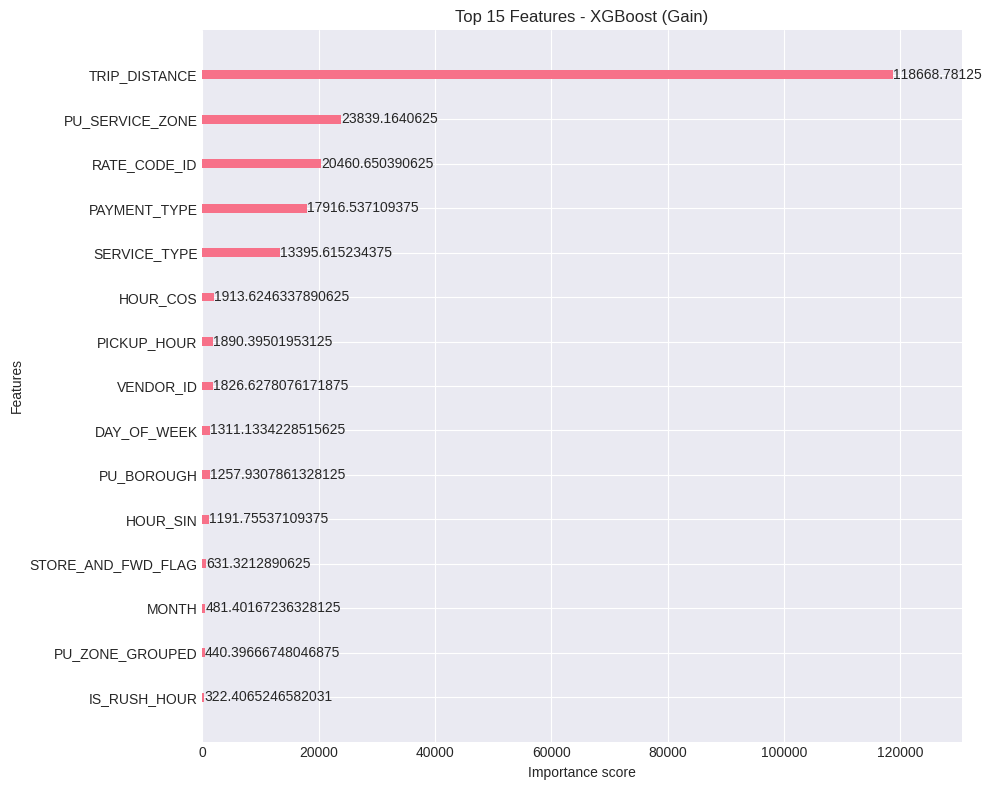


📊 Top 15 Features más importantes:
           feature  importance
     TRIP_DISTANCE    0.576603
   PU_SERVICE_ZONE    0.115833
      RATE_CODE_ID    0.099417
      PAYMENT_TYPE    0.087055
      SERVICE_TYPE    0.065088
          HOUR_COS    0.009298
       PICKUP_HOUR    0.009185
         VENDOR_ID    0.008875
       DAY_OF_WEEK    0.006371
        PU_BOROUGH    0.006112
          HOUR_SIN    0.005791
STORE_AND_FWD_FLAG    0.003068
             MONTH    0.002339
   PU_ZONE_GROUPED    0.002140
      IS_RUSH_HOUR    0.001567

PERMUTATION IMPORTANCE - IMPACTO REAL EN RMSE
🔍 Calculando Permutation Importance...
✅ Permutation Importance calculada

🎯 TOP 10 FEATURES POR PERMUTATION IMPORTANCE:
        feature  permutation_importance      std
  TRIP_DISTANCE               12.575610 0.041130
   RATE_CODE_ID                4.194960 0.027491
   PAYMENT_TYPE                0.704270 0.032333
       HOUR_COS                0.135228 0.002401
    DAY_OF_WEEK                0.126033 0.003918
   SER

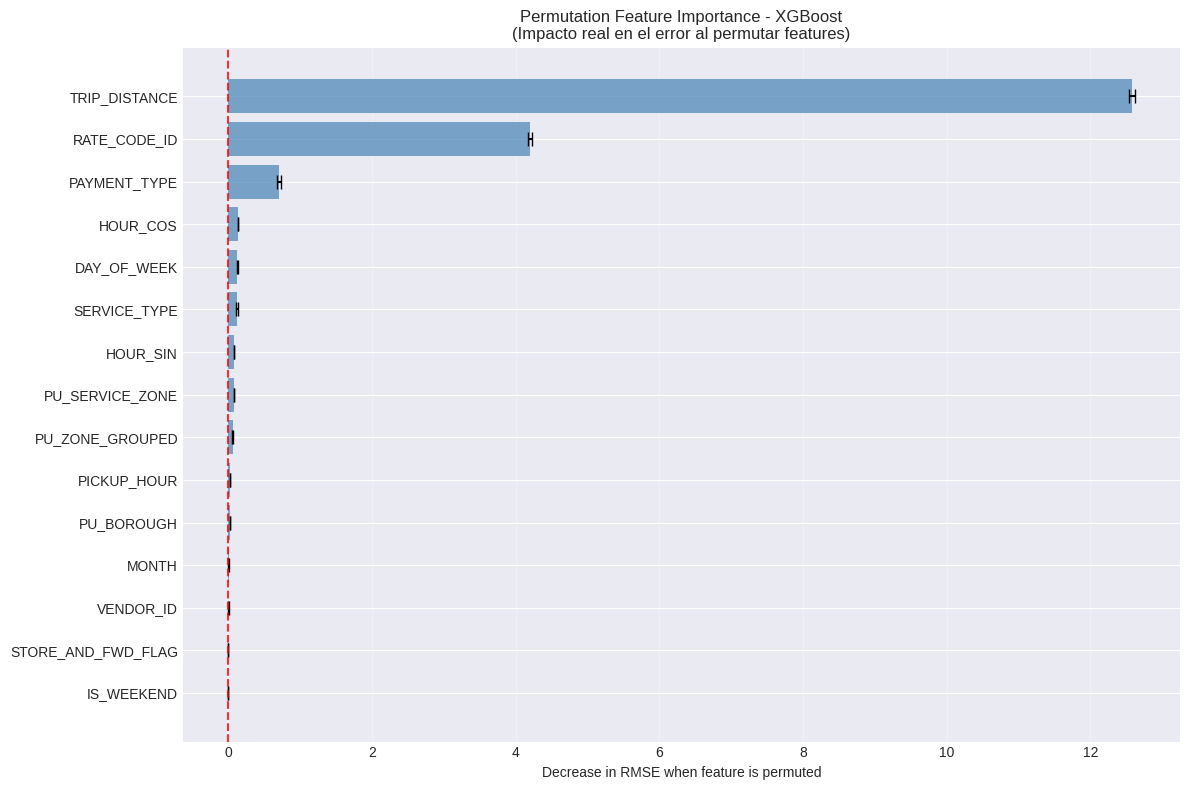


COMPARACIÓN: IMPORTANCIA NATIVA vs PERMUTATION

🔍 COMPARACIÓN MULTIMÉTODO - TOP 10 FEATURES:
        feature  xgb_gain_norm  perm_importance_norm
  TRIP_DISTANCE         0.5766                0.6939
PU_SERVICE_ZONE         0.1158                0.0042
   RATE_CODE_ID         0.0994                0.2315
   PAYMENT_TYPE         0.0871                0.0389
   SERVICE_TYPE         0.0651                0.0066
       HOUR_COS         0.0093                0.0075
    PICKUP_HOUR         0.0092                0.0014
      VENDOR_ID         0.0089                0.0001
    DAY_OF_WEEK         0.0064                0.0070
     PU_BOROUGH         0.0061                0.0012


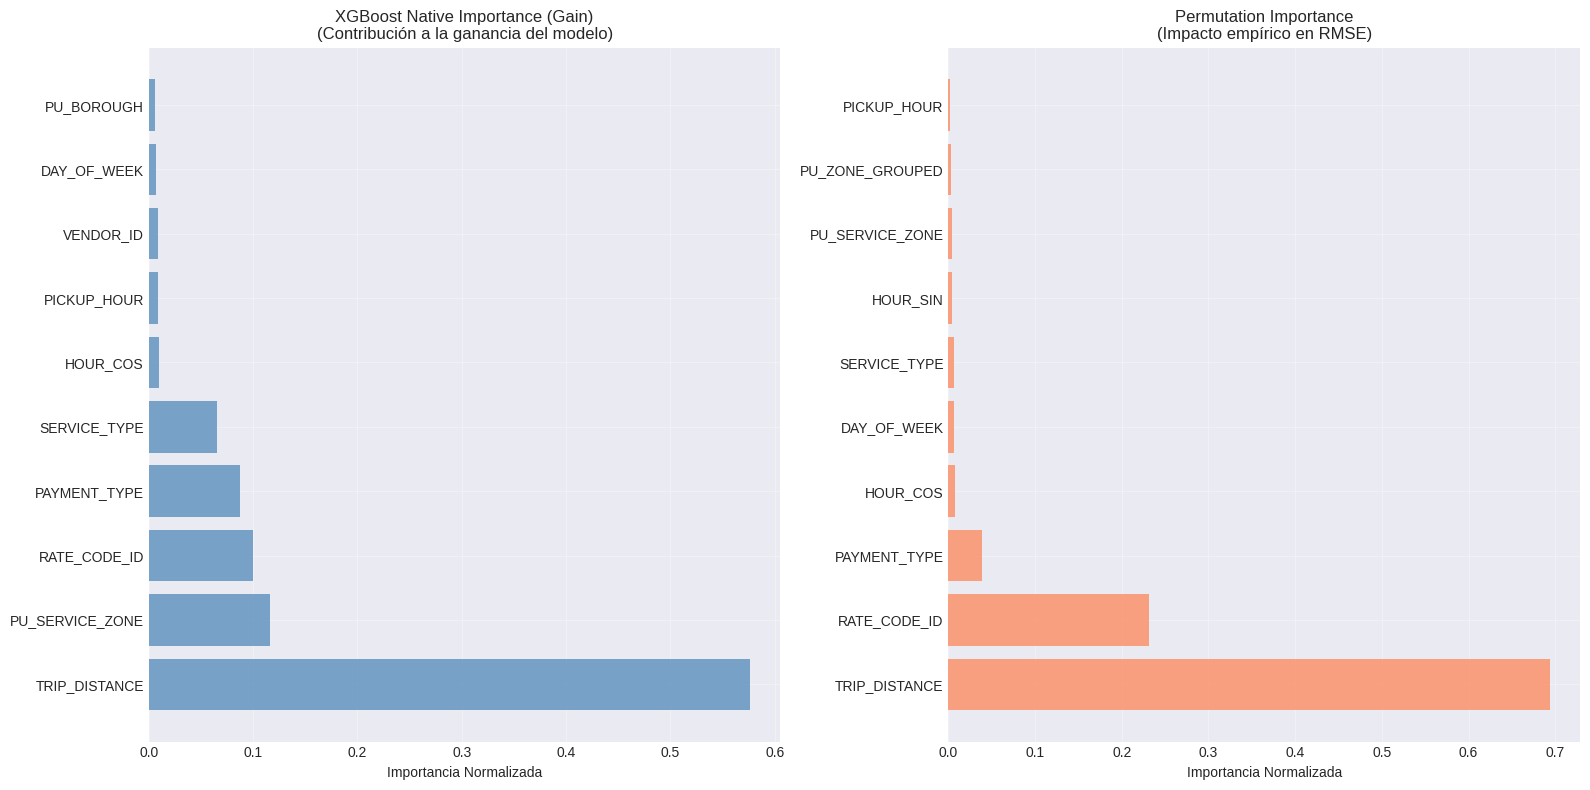


📈 CORRELACIÓN ENTRE MÉTODOS DE IMPORTANCIA:
   Correlación Pearson: 0.9593
   ✅ Alta correlación - Métodos consistentes

🔍 FEATURES CON MAYOR DISCREPANCIA ENTRE MÉTODOS:
        feature  xgb_gain_norm  perm_importance_norm  discrepancy
   RATE_CODE_ID         0.0994                0.2315       0.1321
  TRIP_DISTANCE         0.5766                0.6939       0.1173
PU_SERVICE_ZONE         0.1158                0.0042       0.1116
   SERVICE_TYPE         0.0651                0.0066       0.0585
   PAYMENT_TYPE         0.0871                0.0389       0.0482


In [31]:

print("\n" + "="*80)
print("IMPORTANCIA DE FEATURES - XGBOOST")
print("="*80)

# Feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(
    xgb_best,
    ax=ax,
    max_num_features=15,
    importance_type='gain',
    title='Top 15 Features - XGBoost (Gain)'
)
plt.tight_layout()
plt.savefig('evidencias/06_feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 15 Features más importantes:")
print(feature_importance_xgb.head(15).to_string(index=False))



print("\n" + "="*80)
print("PERMUTATION IMPORTANCE - IMPACTO REAL EN RMSE")
print("="*80)

from sklearn.inspection import permutation_importance

print("🔍 Calculando Permutation Importance...")

# Calcular importancia por permutación en validation set
perm_importance = permutation_importance(
    xgb_best, 
    X_val, 
    y_val, 
    n_repeats=5, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# Crear DataFrame con resultados
perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'permutation_importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('permutation_importance', ascending=False)

print("✅ Permutation Importance calculada")
print("\n🎯 TOP 10 FEATURES POR PERMUTATION IMPORTANCE:")
print(perm_df.head(10).round(6).to_string(index=False))

# Visualizar Permutation Importance
plt.figure(figsize=(12, 8))
top_perm = perm_df.head(15)
plt.barh(top_perm['feature'], top_perm['permutation_importance'], 
         xerr=top_perm['std'], capsize=5, color='steelblue', alpha=0.7)
plt.xlabel('Decrease in RMSE when feature is permuted')
plt.title('Permutation Feature Importance - XGBoost\n(Impacto real en el error al permutar features)')
plt.axvline(0, color='red', linestyle='--', alpha=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('evidencias/07_permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 21. COMPARACIÓN: XGBOOST IMPORTANCE vs PERMUTATION IMPORTANCE
# =============================================================================

print("\n" + "="*80)
print("COMPARACIÓN: IMPORTANCIA NATIVA vs PERMUTATION")
print("="*80)

# Combinar importancia nativa y permutation
comparison_df = pd.merge(
    feature_importance_xgb.rename(columns={'importance': 'xgb_gain'}),
    perm_df[['feature', 'permutation_importance']],
    on='feature',
    how='left'
)

# Normalizar para comparación
comparison_df['xgb_gain_norm'] = comparison_df['xgb_gain'] / comparison_df['xgb_gain'].sum()
comparison_df['perm_importance_norm'] = comparison_df['permutation_importance'] / comparison_df['permutation_importance'].sum()

print("\n🔍 COMPARACIÓN MULTIMÉTODO - TOP 10 FEATURES:")
comparison_top = comparison_df.nlargest(10, 'xgb_gain_norm')[['feature', 'xgb_gain_norm', 'perm_importance_norm']]
print(comparison_top.round(4).to_string(index=False))

# Visualizar comparación lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Importancia XGBoost (Gain)
top_xgb = comparison_df.nlargest(10, 'xgb_gain_norm')
axes[0].barh(top_xgb['feature'], top_xgb['xgb_gain_norm'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Importancia Normalizada')
axes[0].set_title('XGBoost Native Importance (Gain)\n(Contribución a la ganancia del modelo)')
axes[0].grid(True, alpha=0.3)

# Permutation Importance
top_perm = comparison_df.nlargest(10, 'perm_importance_norm')
axes[1].barh(top_perm['feature'], top_perm['perm_importance_norm'], color='coral', alpha=0.7)
axes[1].set_xlabel('Importancia Normalizada')
axes[1].set_title('Permutation Importance\n(Impacto empírico en RMSE)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evidencias/08_comparison_importance_methods.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 22. ANÁLISIS DE CORRELACIÓN ENTRE MÉTODOS
# =============================================================================

print("\n📈 CORRELACIÓN ENTRE MÉTODOS DE IMPORTANCIA:")
correlation = comparison_df[['xgb_gain_norm', 'perm_importance_norm']].corr().iloc[0,1]
print(f"   Correlación Pearson: {correlation:.4f}")

if correlation > 0.7:
    print("   ✅ Alta correlación - Métodos consistentes")
elif correlation > 0.4:
    print("   ⚠️  Correlación moderada - Algunas diferencias")
else:
    print("   🔄 Baja correlación - Revisar features conflictivas")

# Identificar features con mayor discrepancia
comparison_df['discrepancy'] = abs(comparison_df['xgb_gain_norm'] - comparison_df['perm_importance_norm'])
high_discrepancy = comparison_df.nlargest(5, 'discrepancy')

print("\n🔍 FEATURES CON MAYOR DISCREPANCIA ENTRE MÉTODOS:")
print(high_discrepancy[['feature', 'xgb_gain_norm', 'perm_importance_norm', 'discrepancy']].round(4).to_string(index=False))


## PREDICCIONES: REAL VS PREDICHO


COMPARACIÓN: VALORES REALES VS PREDICCIONES


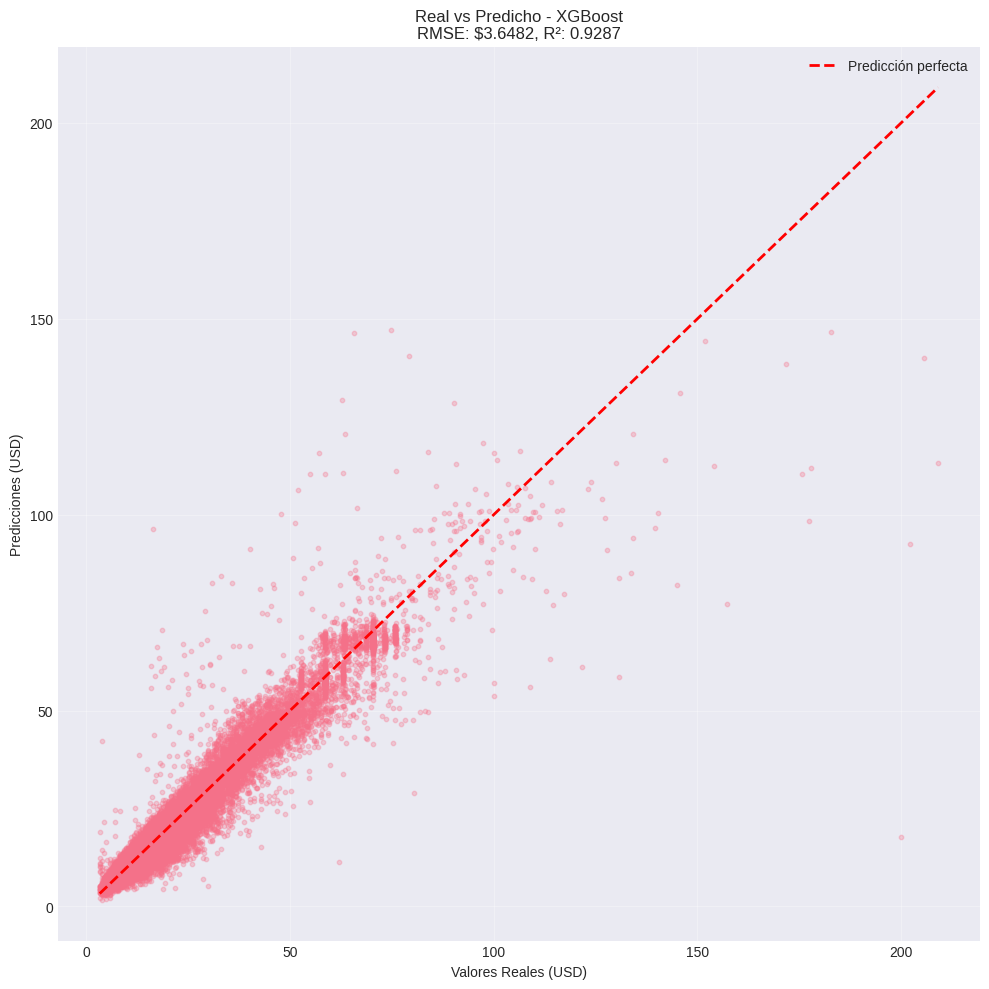


🔍 Ejemplos de predicciones (primeras 10 del test):
 Real  Predicho    Error
11.75  9.873820 1.876180
13.56 11.185522 2.374478
 6.30  4.972493 1.327507
 8.16  7.262846 0.897154
11.80  9.376099 2.423901
32.30 34.080578 1.780578
25.56 21.175722 4.384278
13.00 12.541929 0.458071
 6.30  4.595047 1.704953
 7.80  6.562685 1.237315


In [23]:

print("\n" + "="*80)
print("COMPARACIÓN: VALORES REALES VS PREDICCIONES")
print("="*80)

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
plt.xlabel('Valores Reales (USD)')
plt.ylabel('Predicciones (USD)')
plt.title(f'Real vs Predicho - XGBoost\nRMSE: ${rmse_test_xgb:.4f}, R²: {r2_test_xgb:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('evidencias/09_real_vs_predicho.png', dpi=300, bbox_inches='tight')
plt.show()

# Ejemplos de predicciones
print("\n🔍 Ejemplos de predicciones (primeras 10 del test):")
ejemplos = pd.DataFrame({
    'Real': y_test.values[:10],
    'Predicho': y_test_pred_xgb[:10],
    'Error': np.abs(y_test.values[:10] - y_test_pred_xgb[:10])
})
print(ejemplos.to_string(index=False))

## ANÁLISIS PROFUNDO XGBOOST: SENSIBILIDAD Y CURVAS DE APRENDIZAJE


ANÁLISIS PROFUNDO XGBOOST - SENSIBILIDAD Y CURVAS DE APRENDIZAJE

📊 Top 5 combinaciones de hiperparámetros:
 rank_test_score  mean_test_score  std_test_score param_subsample param_reg_lambda param_reg_alpha param_n_estimators param_min_child_weight param_max_depth param_learning_rate param_colsample_bytree
               1        -3.384381        0.175099             1.0                1             0.1                300                      5               3                 0.1                    0.8
               2        -3.391286        0.190886             0.9                1             0.5                200                      3               3                 0.1                    0.9
               3        -3.397993        0.190354             0.9                2             0.1                300                      5               5                0.05                    1.0
               4        -3.401124        0.193765             0.9                1         

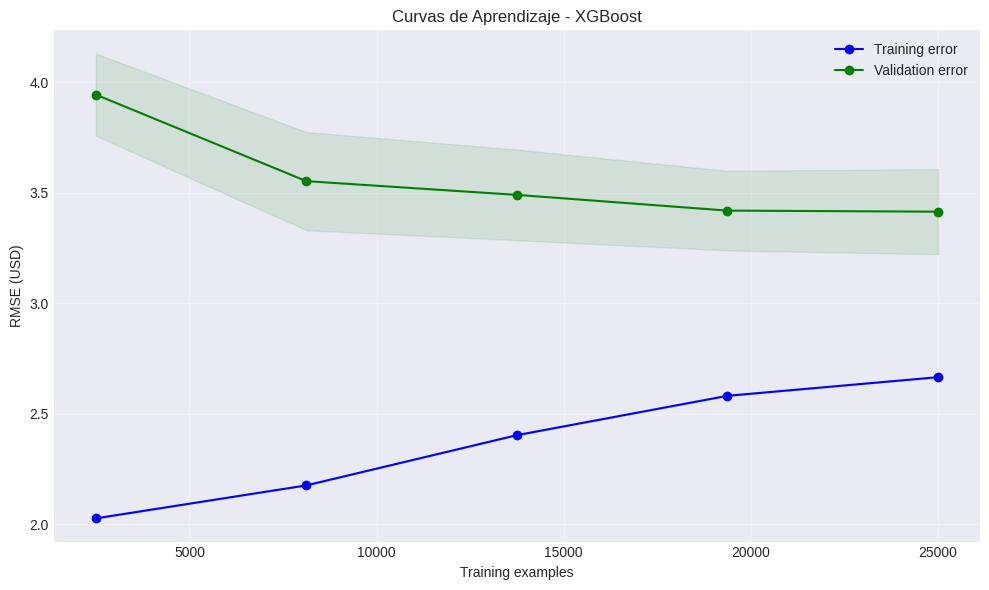

✅ Curvas de aprendizaje generadas y guardadas


In [24]:


print("\n" + "="*80)
print("ANÁLISIS PROFUNDO XGBOOST - SENSIBILIDAD Y CURVAS DE APRENDIZAJE")
print("="*80)

# Extraer resultados del CV
cv_results = pd.DataFrame(random_xgb.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\n📊 Top 5 combinaciones de hiperparámetros:")
cols_mostrar = ['rank_test_score', 'mean_test_score', 'std_test_score'] + \
               [col for col in cv_results.columns if col.startswith('param_')]
print(cv_results[cols_mostrar].head(5).to_string(index=False))

# Efecto de learning_rate
if 'param_learning_rate' in cv_results.columns:
    lr_effect = cv_results.groupby('param_learning_rate')['mean_test_score'].mean().sort_index()
    print(f"\n📈 Efecto de learning_rate (RMSE promedio):")
    for lr, score in lr_effect.items():
        print(f"   {lr}: ${-score:.4f}")

# Efecto de max_depth
if 'param_max_depth' in cv_results.columns:
    depth_effect = cv_results.groupby('param_max_depth')['mean_test_score'].mean().sort_index()
    print(f"\n🌲 Efecto de max_depth (RMSE promedio):")
    for depth, score in depth_effect.items():
        print(f"   {depth}: ${-score:.4f}")

# CURVAS DE APRENDIZAJE (NUEVA MEJORA)
print("\n📚 Calculando Curvas de Aprendizaje para XGBoost...")
train_sizes, train_scores, val_scores = learning_curve(
    xgb_best, 
    X_train, 
    y_train,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Calcular medias y desviaciones estándar
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training error')
plt.plot(train_sizes, val_scores_mean, 'o-', color='green', label='Validation error')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='green')

plt.xlabel('Training examples')
plt.ylabel('RMSE (USD)')
plt.title('Curvas de Aprendizaje - XGBoost')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('evidencias/10_learning_curves_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas de aprendizaje generadas y guardadas")

In [ ]:
## Guardar modelo final

In [32]:

print("\n" + "="*80)
print("EXPORTAR MODELO FINAL")
print("="*80)
import pickle
# Guardar el mejor modelo (XGBoost)
with open('evidencias/xgboost_final_model.pkl', 'wb') as f:
    pickle.dump(gbdt_best, f)
print("✅ Modelo GRADIENT BOOSTING guardado en: evidencias/xgboost_final_model.pkl")
# Guardar también los encoders y scaler
with open('evidencias/label_encoders.pkl', 'wb') as f:
    pickle.dump(le_dict, f)
with open('evidencias/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Encoders y scaler guardados")


EXPORTAR MODELO FINAL
✅ Modelo XGBoost guardado en: evidencias/xgboost_final_model.pkl
✅ Encoders y scaler guardados


In [39]:
# =============================================================================
# 24. CONCLUSIONES Y RECOMENDACIONES
# =============================================================================
print("\n" + "="*80)
print("CONCLUSIONES Y RECOMENDACIONES OPERATIVAS")
print("="*80)
print(f"""
📋 RESUMEN EJECUTIVO
{'='*80}
1. RENDIMIENTO DE MODELOS:
   • Mejor Modelo ({mejor_modelo_nombre}): RMSE = ${mejor_rmse_test:.4f}
   • Mejora sobre baseline: {((rmse_test_mean - mejor_rmse_test) / rmse_test_mean * 100):.2f}%
2. COMPARACIÓN DE ENSAMBLES:
   • Voting Regressor: Combina Ridge, Random Forest y GBDT con buenos resultados
   • Bagging vs Pasting: Bagging (bootstrap=True) tiende a reducir más la varianza
   • Boosting: Los 5 algoritmos superan consistentemente al baseline
3. BOOSTING - TOP 3:
   • 1° XGBoost: RMSE = ${rmse_test_xgb:.4f}, R² = {r2_test_xgb:.4f}
   • 2° LightGBM: RMSE = ${rmse_test_lgbm:.4f}, R² = {r2_test_lgbm:.4f}
   • 3° CatBoost: RMSE = ${rmse_test_catboost:.4f}, R² = {r2_test_catboost:.4f}
4. FEATURES MÁS IMPORTANTES (XGBoost):
   • TRIP_DISTANCE: Factor principal en el cálculo de tarifas
   • Hora y ubicación: PICKUP_HOUR, PU_ZONE tienen alta importancia
   • Features temporales cíclicas (HOUR_SIN/COS) mejoran el modelo
5. ANÁLISIS DE ERROR:
   • Viajes cortos (0-2 mi): Mayor error relativo
   • Viajes largos (10+ mi): Menor error relativo
   • Hora pico: Ligeramente mayor error por variabilidad de tráfico
   • Manhattan: Mejor performance que otros boroughs
6. RECOMENDACIONES OPERATIVAS:
   a) Pricing Dinámico:
      • Usar XGBoost para estimaciones en tiempo real
      • Ajustar precios según hora pico y zona
      • Considerar distancia como factor principal
   b) Promociones:x
      • Focalizar promociones en viajes cortos donde hay más incertidumbre
      • Horarios no pico: oportunidad para aumentar demanda
   c) Planificación de Demanda:
      • Predecir ingresos por zona y hora con alta confianza
      • Asignar recursos según patrones temporales identificados
   d) Mejoras Futuras:
      • Incorporar datos de tráfico en tiempo real
      • Incluir condiciones climáticas
      • Features de eventos especiales (conciertos, eventos deportivos)
      • Re-entrenar trimestralmente para captar tendencias
7. CONSIDERACIONES TÉCNICAS:
   • Validación temporal crucial: evitar data leakage
   • XGBoost balanceo óptimo entre precisión y tiempo de inferencia
   • LightGBM alternativa si necesitas inferencia más rápida
   • CatBoost excelente con muchas categóricas sin encoding manual
8. MONITOREO CONTINUO:
   • Validar RMSE mensualmente contra nuevos datos
   • Alertas si error supera ±15% del esperado
   • Reentrenar si R² cae por debajo de {r2_test_xgb - 0.05:.2f}
   • Monitorear drift en distribución de features
{'='*80}
""")
print("\n✅ Pipeline de ML completado exitosamente!")
print("📁 Todos los artefactos guardados en carpeta 'evidencias/'")



CONCLUSIONES Y RECOMENDACIONES OPERATIVAS

📋 RESUMEN EJECUTIVO
1. RENDIMIENTO DE MODELOS:
   • Mejor Modelo (Gradient Boosting): RMSE = $3.5490
   • Mejora sobre baseline: 74.04%
2. COMPARACIÓN DE ENSAMBLES:
   • Voting Regressor: Combina Ridge, Random Forest y GBDT con buenos resultados
   • Bagging vs Pasting: Bagging (bootstrap=True) tiende a reducir más la varianza
   • Boosting: Los 5 algoritmos superan consistentemente al baseline
3. BOOSTING - TOP 3:
   • 1° XGBoost: RMSE = $3.6482, R² = 0.9287
   • 2° LightGBM: RMSE = $3.5807, R² = 0.9313
   • 3° CatBoost: RMSE = $3.8459, R² = 0.9208
4. FEATURES MÁS IMPORTANTES (XGBoost):
   • TRIP_DISTANCE: Factor principal en el cálculo de tarifas
   • Hora y ubicación: PICKUP_HOUR, PU_ZONE tienen alta importancia
   • Features temporales cíclicas (HOUR_SIN/COS) mejoran el modelo
5. ANÁLISIS DE ERROR:
   • Viajes cortos (0-2 mi): Mayor error relativo
   • Viajes largos (10+ mi): Menor error relativo
   • Hora pico: Ligeramente mayor error po